In [1]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd4843 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 24 × 12th Gen Intel(R) Core(TM) i9-12900K
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, alderlake)
Threads: 8 default, 0 interactive, 4 GC (on 24 virtual cores)
Environment:
  JULIA_NUM_THREADS = 8


In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

  Activating project at `C:\Users\o6m1g\Documents\GitHub\ASMC-BayesCV`


Status `C:\Users\o6m1g\Documents\GitHub\ASMC-BayesCV\Project.toml`
  [0bf59076] AdvancedHMC v0.8.0
  [336ed68f] CSV v0.10.15
  [a93c6f00] DataFrames v1.7.0
  [31c24e10] Distributions v0.25.120
  [4138dd39] JLD v0.13.5
  [b964fa9f] LaTeXStrings v1.4.0
  [6fdf6af0] LogDensityProblems v2.1.2
  [86f7a689] NamedArrays v0.10.4
  [ce719bf2] PSIS v0.9.8
  [91a5bcdd] Plots v1.40.17
  [92933f4c] ProgressMeter v1.10.4
  [f2b01f46] Roots v2.2.8
  [2913bbd2] StatsBase v0.34.5
  [4c63d2b9] StatsFuns v1.5.0
  [f3b207a7] StatsPlots v0.15.7
⌅ [fce5fe82] Turing v0.39.6
  [ade2ca70] Dates
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


# Setup

In [3]:
include("Init.jl")

In [4]:
println("Running on ", Threads.nthreads(), " threads.")

Running on 8 threads.


In [5]:
using Turing

In [104]:
RUN_MCMC = false
RUN_aSMC = true;

In [7]:
# Tag by timestamp
SESSION = Dates.format(now(), "yyyy-mm-dd-HH-MM-SS");

# Data

In [113]:
# Initial data trimming to meet file size constraint
# sales_train = CSV.read(joinpath("data", "m5-forecasting-accuracy",
#         "sales_train_validation.csv"), DataFrame);
# sales_train = filter(row -> 1 <= parse(Int64, split(row.item_id, "_")[end]) <= 30, sales_train)
# CSV.write(joinpath("data", "m5-forecasting-accuracy", "data.csv"), sales_train);

In [114]:
# Load data
sales_train = CSV.read(joinpath("data", "m5-forecasting-accuracy",
        "data.csv"), DataFrame);

# Data container to hold structured panel and metadata
struct Data_M5
    y::Any                            # Response matrix (item × store), standardized
    K_axis::Vector{String}            # Unique item IDs
    S_axis::Vector{String}            # Store IDs
    G_axis::Matrix{Float64}           # groups by cat_id, one-hot indicator matrix
    K::Int64                          # Number of unique items
    S::Int64                          # Number of unique stores
    G::Int64                          # Number of unique groups
    valid_idx::Vector{Vector{String}} # CV fold indices; vector of item_ids
end

In [116]:
let
    Random.seed!(1) # Ensure reproducible shuffling

    # Define axis
    K_axis = [item_id for item_id in unique(sales_train.item_id)
            if 1 <= parse(Int64, split(item_id, "_")[end]) <= 30] # Filter items for simplicity
    S_axis = sales_train.store_id |> unique # Store axis
    axes = (K_axis, S_axis)
    
    # Initialize (missing) complete panel
    y = NamedArray(
        Array{Union{Missing, Float64}, 2}(missing, length.(axes)...),
        axes,
        (:k, :s),
    )

    # Fill panel
    for k=K_axis, s=S_axis
        mask = (sales_train.item_id .=== k) .& (sales_train.store_id .=== s)
        @assert sum(mask) == 1 # assert one row per item-store (OK for M5)

        # Extract daily sales vector during d_1 ~ d_1913
        _data = sales_train[mask, ["d_$(t)" for t in 1:1913]] |> Matrix |> vec

        # Compute mean of first-order differences
        y[Name(k), Name(s)] = _data |> diff |> mean
    end

    # Standardize
    y = NamedArray(
        (Matrix(y) .- mean(y)) / std(y),
        axes,
        (:k, :s),
    )

    # Manually generate validation index
    G_axis = K_axis .|> (k -> k[1:end-4]) # Truncate suffix (e.g., "FOODS_3_012" → "FOODS_3")
    K = 10
    valid_idx = repeat([String[]], K) # Preallocate K-fold validation index vector

    if in("valid_idx.jld", readdir(joinpath("data", "m5-forecasting-accuracy")))
        valid_idx = load(joinpath("data", "m5-forecasting-accuracy", "valid_idx.jld"))["data"]
    else
        # Create stratified folds:
        # for each group (e.g., "FOODS_3"),
        # shuffle items and split into 10 folds (3 items each)
        for g in unique(G_axis)
            partition_g = Iterators.partition(K_axis[G_axis .== g] |> shuffle, 3) |> collect
            @assert length(partition_g) == K # assert number of items: OK only for this M5 data
            # Distribute partitioned items into validation folds
            for fold_i in 1:K
                valid_idx[fold_i] = [valid_idx[fold_i]; partition_g[fold_i]]
            end
        end
        save(joinpath("data", "m5-forecasting-accuracy", "valid_idx.jld"),
            "data", data.valid_idx)
    end

    # Compute axis lengths
    K = K_axis |> unique |> length
    S = S_axis |> unique |> length
    G = G_axis |> unique |> length

    # Map group labels to integers and encode as one-hot matrix
    _map = Dict(g => i for (i, g) in enumerate(unique(G_axis))) # label → integer index
    G_axis = [_map[g] for g in G_axis] # item-level integer group assignments
    G_axis = indicatormat(G_axis)' # (group × item) layout

    # Store everything in Data_M5 object
    global data = Data_M5(y, K_axis, S_axis, G_axis, K, S, G, valid_idx)
    # @info size(data.y) # log panel dimensions
end;

209-element Vector{String15}:
 "HOBBIES_1_001"
 "HOBBIES_1_002"
 "HOBBIES_1_003"
 "HOBBIES_1_004"
 "HOBBIES_1_005"
 "HOBBIES_1_006"
 "HOBBIES_1_007"
 "HOBBIES_1_008"
 "HOBBIES_1_009"
 "HOBBIES_1_010"
 "HOBBIES_1_011"
 "HOBBIES_1_012"
 "HOBBIES_1_013"
 ⋮
 "FOODS_3_019"
 "FOODS_3_020"
 "FOODS_3_021"
 "FOODS_3_022"
 "FOODS_3_023"
 "FOODS_3_024"
 "FOODS_3_025"
 "FOODS_3_026"
 "FOODS_3_027"
 "FOODS_3_028"
 "FOODS_3_029"
 "FOODS_3_030"

LoadError: UndefVarError: `a` not defined

# MCMC

In [11]:
@model function Model(
        data::Data_M5,
        leave_g::Vector{String}, # Vector of item_ids for cross-validation exclusion
        ϕ::Union{Float64, Int64}, # Power coefficient for likelihood tempering
    )

    # Prior: Σ ~ InverseWishart(ν_0 = 2data.S, S_0 = I))
    # Bartlett decomposition: Wishart Σ⁻¹ = (LA)(LA)ᵀ = AAᵀ w/ A lower-triangular
    # y ~ N(μ, Σ = A⁻ᵀA⁻¹) ⇒ Aᵀ(y - μ) ~ N(0, I)
    L, A = I(data.S), zeros(data.S, data.S)
    for s_i in 1:data.S
        A[s_i,s_i] ~ Chi(2data.S - s_i + 1) # = c[s_i]
        for s_j in 1:s_i-1
            A[s_i,s_j] ~ Normal(0,1)
        end
    end
    
    α_s ~ MvNormal(I(data.S)) # Store-level effects
    
    α_g ~ MvNormal(I(data.G)) # Group-level effects
    X_g = data.G_axis * α_g   # Expand to item-level
    
    for (k_i, k) in enumerate(data.K_axis)
        _power = k ∈ leave_g ? (1 - ϕ) : 1 # fractional likelihood for left-out items
        μ = α_s .+ X_g[k_i] # Item-wise mean over stores: store + group
        log_ℓ = _power * logpdf(MvNormal(I(data.S)), A' * (data.y[:k => k] - μ)) # Covariance over store
        Turing.@addlogprob! log_ℓ
    end
end

Model (generic function with 2 methods)

In [12]:
function run_MCMC(; leave_g::Vector{String}, save_bool::Bool=false)
    """
    Function to run MCMC, leaving items (observations) in leave_g the vector of items out.
    Set leave_g = ["none"] to target baseline posterior.
    """

    @assert in(leave_g, [[["none"]]; data.valid_idx])
    fold_i = findall(leave_g == valid_idx for valid_idx in data.valid_idx)
    @assert 0 ≤ length(fold_i) ≤ 1 fold_i
    fold_i = length(fold_i) == 1 ? fold_i[1] : -1

    # Instantiate baseline posterior
    _model = nothing
    if leave_g == -1
        _model = Model(data, ["none"], 0)
    else
        _model = Model(data, leave_g, 1)
    end
    _model = Model(data, leave_g, 0)
    ℓπ = LogDensityFunction(_model)
    Turing.DynamicPPL.link!!(ℓπ.varinfo, _model)

    D = LogDensityProblems.dimension(ℓπ) # Dimensionality of parameter space
    metric = DiagEuclideanMetric(D)
    hamiltonian = Hamiltonian(metric, ℓπ)

    # Sampling settings
    n_burn, n_adapts, n_samples, thin = 1_000, 1_000, 3_000, 3
    initial_θ = ones(D)
    initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
    integrator = Leapfrog(initial_ϵ)
    kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

    time = @elapsed samples, stats = sample(
        hamiltonian, kernel, initial_θ, n_samples + n_burn, adaptor, n_adapts;
        progress=true)

    # Post-process samples:
    # - drop burn-in;
    # - apply thinning (every 3rd)
    # - invert bijector, recover params in original space
    chain = samples[n_burn+1:thin:end] .|> Turing.inverse(Turing.bijector(_model))

    # Save output
    if save_bool
        _dir = joinpath("output_$(SESSION)", "M5", "mcmc")
        isdir(_dir) || mkpath(_dir) # Ensure path is present
        if fold_i == -1
            save(joinpath(_dir, "chain.jld"), "data", chain)
            CSV.write(joinpath(_dir, "stats_df.csv"), stats |> DataFrame)
        else
            save(joinpath(_dir, "chain_lso-$(fold_i).jld"), "data", chain)
        end
    end

    (; chain, stats, time)
end

run_MCMC (generic function with 1 method)

## Initial draw

In [10]:
Random.seed!(1)
RUN_MCMC && ((; chain, stats, time) = run_MCMC(leave_g=["none"]; save_bool=true));

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Sampling 100%|███████████████████████████████| Time: 0:12:16
                                    iterations: 4000
                   ratio_divergent_transitions: 0.0
   ratio_divergent_transitions_during_adaption: 0.0
                                       n_steps: 15
                                     is_accept: true
                               acceptance_rate: 0.9509715326934198
                                   log_density: -2384.063908858131
                            hamiltonian_energy: 2421.3358314882676
                      hamiltonian_energy_error: -0.27143739903885944

## Naive LSO

In [12]:
Random.seed!(1)

if RUN_MCMC
    
    times_M5 = Float64[] # Runtime for each MCMC-LSO run
    
    # Loop over each folds for bruteforce MCMC-LSO
    for (fold_i, leave_g) in enumerate(data.valid_idx)
        @info "Fold $(fold_i)"
        
        (; chain, stats, time) = run_MCMC(leave_g=leave_g; save_bool=true)
        push!(times_M5, time)
        
        # Save intermediate results after each iteration (in case of interruption)
        _dir = joinpath("output_$(SESSION)", "M5", "mcmc")
        isdir(_dir) || mkpath(_dir) # Ensure path is present
        save(joinpath(_dir, "times_naive-lso.jld"), "data", times_M5)
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\o6m1g\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Sampling 100%|███████████████████████████████| Time: 0:15:36
                                    iterations: 4000
                   ratio_divergent_transitions: 0.0
   ratio_divergent_transitions_during_adaption: 0.01
                                       n_steps: 15
                                     is_accept: true
                               acceptance_rate: 0.9848288096342747
                                   log_density: -2200.9922507090364
                            hamiltonian_energy: 2235.2269213304976
                      hamiltonian_energy_error: -0.060417252259867

# LSO

In [14]:
chain = load(joinpath("output", "M5", "mcmc", "chain.jld"))["data"];
stats = CSV.read(joinpath("output", "M5", "mcmc", "stats_df.csv"), DataFrame);

## aSMC

In [15]:
function SMCS_M5(chain::Vector{Vector{Float64}}, leave_g::Vector{String}; k̂_threshold::Float64=0.7)

    # Unconstrain initial draws
    model   = Model(data, leave_g, 0) # draws are from this baseline
    draws_0 = chain .|> Turing.bijector(model) |> vecvec2mat # as matrix

    # Define problem dimensions
    R      = size(draws_0, 1)    # number of baseline MCMC draws
    D      = size(draws_0, 2)    # dimension of posterior
    L      = length(data.K_axis) # max number of intermediate distributions

    # Obtain unconstrained prior draw
    _names = sample(model, Prior(), 1).name_map.parameters .|> String # param names
    Θ_0    = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )

    # Allocate storage
    particles = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    weights   = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    ϕ_history = NamedArray(zeros(L+1), 0:L, :l)
    mcmc_flag = NamedArray(zeros(L+1), 0:L, :l)
    k̂         = nothing
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # Effective sample size
    function _ess(_w::Vector{Float64})::Float64
        1 / sum(@. exp(2 * log(_w)))
    end
    
    # Log ratio at given proposal l-1 and target l for n-th particle
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end

    # MCMC kernel
    initial_ϵ, n_steps, mass = stats.step_size[end], min(15, stats.n_steps[end]), vec(var(chain .|> vec |> vecvec2mat; dims=1))
    function _move(initial_θ::Vector{Float64},
            n_samples::Int, n_adapts::Int,
            ℓπ::LogDensityFunction)::Vector{Float64}
        metric = DiagEuclideanMetric(mass)
        hamiltonian = Hamiltonian(metric, ℓπ)
        integrator = Leapfrog(initial_ϵ)
        adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
        kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(n_steps)))
        rng = Random.TaskLocalRNG()
        samples, stats = sample(rng, hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts;
            verbose=false, progress=false)
        samples[end]
    end
    
    # Set initial values, starting index
    particles[:l => 0] = Θ_0 # sample from prior
    weights[:l => 0] = repeat([1/R], R)
    ϕ_history[:l => 0] = 0.
    
    time = @elapsed for l in 1:L
        # Inherit case-deleted model from previous iteration
        model_0 = Model(data, leave_g, ϕ_history[:l => l-1])
        ℓπ_0 = LogDensityFunction(model_0)
        Turing.DynamicPPL.link!!(ℓπ_0.varinfo, model_0)

        # Define (until ↦ ESS) map
        function _ϕ2reff(ϕ::Union{Float64, Int64})::Float64
            @assert 0 <= ϕ <= 1 # data.N_g[leave_g]
            model_1 = Model(data, leave_g, ϕ)
            ℓπ_1 = LogDensityFunction(model_1)
            Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)
            
            _ESS = _log_weights |> _normalize |> _ess
            _ESS - R/2
        end
        
        # Initialize next distribution parameter
        ϕ_1 = nothing
        
        # Case 1: ESS is above threshold
        if _ϕ2reff(1) > 0
            # Define next as final distribution
            ϕ_1 = 1
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)

            # Adaptive
            _psis = psis(_log_weights; warn=false)

            # Case 1-1: PSIS
            if _psis.pareto_shape < k̂_threshold
                mcmc_flag[:l => l] = false; @info "ϕ=$(ϕ_1), PSIS"
                particles[:l => l] = particles[:l => l-1]
                weights[:l => l] = _psis.log_weights |> _normalize
                k̂ = _psis.pareto_shape 
                ϕ_history[:l => l] = ϕ_1
            
            # Case 1-2: MCMC kernel
            else
                mcmc_flag[:l => l] = true; @info "ϕ=$(ϕ_1), MCMC"
                
                A_0 = wsample(1:R, _log_weights |> _normalize, R)
                _begin = particles[:l => l-1, :n => A_0]
                _end = particles[:l => l, :n => 1:R] |> similar
                #@showprogress for n in 1:R
                p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                    _end[n,:] = _move(_begin[n,:], 1, 0, ℓπ_1)
                    ProgressMeter.next!(p)
                end
                particles[Name(l), :, :,] = _end
                weights[:l => l] = repeat([1/R], R)
                ϕ_history[:l => l] = ϕ_1
            end
            
            L = l; break # Break loop

        # Case 2: ESS is below threshold
        else
            mcmc_flag[:l => l] = true
            
            # Find next distribution
            ϕ_1 = find_zero(_ϕ2reff, (ϕ_history[:l => l-1] + 1e-4, 1),
                xtol=0.1, maxiters=10, verbose=true)
            @info "Targeting ϕ=$(ϕ_1)"
            
            # Compute log weights
            model_1 = Model(data, leave_g, ϕ_1)
            ℓπ_1 = LogDensityFunction(model_1)
            Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
            _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R]
            _log_weights = _log_weights .- maximum(_log_weights)
            
            A_0 = wsample(1:R, _log_weights |> _normalize, R)
            _begin = particles[:l => l-1, :n => A_0]
            _end = particles[:l => l, :n => 1:R] |> similar
            #@showprogress for n in 1:R
            p = ProgressMeter.Progress(R); @Threads.threads for n in 1:R
                _end[n,:] = _move(_begin[n,:], 1, 0, ℓπ_1)
                ProgressMeter.next!(p)
            end
            particles[Name(l), :, :,] = _end
            weights[:l => l] = repeat([1/R], R)
            ϕ_history[:l => l] = ϕ_1
        end
    end

    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]
    mcmc_flag = mcmc_flag[Name(L)]
    ϕ_history = ϕ_history[Name.(0:L)]

    (;
        R,         # Number of particles
        D,         # Dimensionality of parameter space
        L,         # Number of intermediate distributions
        particles, # NamedArray of particles
        weights,   # Associated particle weights
        ϕ_history, # History of ϕ (= 1 - ρ | ρ: power coef) values
        k̂,         # Pareto shape diagnostic estimate, if any
        mcmc_flag, # true if invariant kernel applied
        time,      # SMC runtime
    )
end

SMCS_M5 (generic function with 1 method)

## PSIS

In [16]:
function PSIS_M5(chain::Vector{Vector{Float64}}, leave_g::Vector{String};
        k̂_threshold::Float64=0.7 # not used
    )
    
    model = Model(data, leave_g, 0)
    draws_0 = chain .|> Turing.bijector(model) |> vecvec2mat # unconstrain
    
    # Define problem dimensions
    R = size(draws_0, 1)
    D = size(draws_0, 2)
    L = 1 # maximum
    _names = sample(model, Prior(), 1).name_map.parameters .|> String
    
    # Obtain unconstrained prior draw
    Θ_0 = NamedArray(
        draws_0,
        (1:R, _names),
        (:n, :d),
    )
    
    # Initialize containers
    particles   = NamedArray(zeros(L+1, R, D), (0:L, 1:R, _names), (:l, :n, :d))
    # log_weights = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    weights     = NamedArray(zeros(L+1, R), (0:L, 1:R), (:l, :n))
    k̂           = nothing # NamedArray(zeros(L+1), 0:L, :l)
    
    # Log weights normalizer
    function _normalize(_log_w::Vector{Float64})::Vector{Float64}
        # normalize log weights
        _w = exp.(_log_w .- maximum(_log_w))
        _w = _w / sum(_w)
        _w
    end

    # Log ratio
    function log_G(ℓπ_0, ℓπ_1, l::Int, n::Int)::Float64
        _particle = particles[:l => l-1, :n => n]
        log_γ_0 = LogDensityProblems.logdensity(ℓπ_0, _particle)
        log_γ_1 = LogDensityProblems.logdensity(ℓπ_1, _particle)
        log_γ_1 - log_γ_0
    end
    
    # Set initial values, starting index
    particles[:l => 0] = Θ_0 # sample from prior
    weights[:l => 0] = repeat([1/R], R)

    ϕ_0 = 0
    model_0 = Model(data, leave_g, ϕ_0)
    ℓπ_0 = LogDensityFunction(model_0)
    Turing.DynamicPPL.link!!(ℓπ_0.varinfo, model_0)
    
    # Compute log weights
    ϕ_1 = 1
    model_1 = Model(data, leave_g, ϕ_1)
    ℓπ_1 = LogDensityFunction(model_1)
    Turing.DynamicPPL.link!!(ℓπ_1.varinfo, model_1)
    
    time = @elapsed (l = 1;
        _log_weights = [log_G(ℓπ_0, ℓπ_1, l, n) for n in 1:R];
        _log_weights = _log_weights .- maximum(_log_weights);
        
        # PSIS
        _psis = psis(_log_weights; warn=false);
        particles[:l => l] = particles[:l => l-1];
        weights[:l => l] = _psis.log_weights |> _normalize;
    )
    
    k̂ = _psis.pareto_shape
    particles = particles[Name(L),:,:]
    weights   = weights[Name(L), :]

    (; R, D, L, particles, weights, k̂, time)
end

PSIS_M5 (generic function with 1 method)

# Run

In [17]:
# Function to run aSMC-LSO-CV or PSIS-LSO-CV across all counties
function run(
        use_chain::Vector{Vector{Float64}}, # Input baseline MCMC chain
        Sampler_M5::Union{typeof(SMCS_M5), typeof(PSIS_M5)};
        save_bool::Bool=false,              # Saving output
        k̂_threshold::Float64=0.7,           # Optional threshold (unused for main analysis)
)
    
    R = length(use_chain) # Number of posterior particles

    # Init per-group storage
    particles    = []
    weights      = []
    ϕ_histories  = []
    k̂s           = []
    times        = Float64[]

    @info "First pilot run"
    Sampler_M5(use_chain, data.valid_idx[1]; k̂_threshold=k̂_threshold)
    
    for (fold_i, leave_g) in enumerate(data.valid_idx)
        @info "Fold: $(fold_i)"
        
        # Run aSMC or PSIS
        results = Sampler_M5(use_chain, leave_g; k̂_threshold=k̂_threshold)
        # aiueo
        # Record output
        push!(particles,   results[:particles])
        push!(weights,     results[:weights])
        push!(k̂s,          results[:k̂])
        push!(times,       results[:time])
        Sampler_M5 == SMCS_M5 && push!(ϕ_histories, results[:ϕ_history])
        # break
    end

    if save_bool
        # Define folder to save output
        _dir = joinpath(
            "output_$(SESSION)",
            "M5",
            Sampler_M5 == SMCS_M5 ? "smc" : "psis"
        )
        isdir(_dir) || mkpath(_dir) # Ensure path is present

        # Save (after un-naming)
        # Sizes are: G = groups, R = particles, D = parameter dim
        save(joinpath(_dir, "particles_threshold-$(k̂_threshold).jld"),
            "data", particles .|> Matrix) # [G][R,D]
        save(joinpath(_dir, "weights_threshold-$(k̂_threshold).jld"),
            "data", weights .|> Vector) # [G][R]
        save(joinpath(_dir, "khats_threshold-$(k̂_threshold).jld"),
            "data", k̂s) # G
        save(joinpath(_dir, "times_threshold-$(k̂_threshold).jld"),
            "data", times) # G
        Sampler_M5 == SMCS_M5 && save(
            joinpath(_dir, "histories_threshold-$(k̂_threshold).jld"),
            "data", ϕ_histories .|> Vector) # [G][L_g]
    end
    
    return
end

run (generic function with 1 method)

In [17]:
Random.seed!(1)
RUN_aSMC && run(chain, SMCS_M5; save_bool=true);

[ Info: Fold: 1


Results of univariate zero finding:

* Converged to: 0.2769941406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.23903124999999997, 0.28025624999999993 )
(a₆, b₆) = ( 0.25415937499999991, 0.28025624999999993 )
(a₇, b₇) = ( 0.26720781249999992, 0.28025624999999993 )
(a₈, b₈) = ( 0.2737320312499999, 0.28025624999999993 )
(a₉, b₉) = ( 0.2737320312499999, 0.27699414062499988 )
(a₁₀, b₁₀) = ( 0.27536308593749986, 0.27699414062499988 )



[ Info: Targeting ϕ=0.2769941406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.4703667013168333
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.27709414062499987, 0.52709414062499982 )
(a₁, b₁) = ( 0.39532060546874986, 0.52709414062499982 )
(a₂, b₂) = ( 0.45443383789062486, 0.52709414062499982 )
(a₃, b₃) = ( 0.45443383789062486, 0.48399045410156238 )
(a₄, b₄) = ( 0.46921214599609362, 0.48399045410156238 )
(a₅, b₅) = ( 0.46921214599609362, 0.476601300048828 )
(a₆, b₆) = ( 0.46921214599609362, 0.47290672302246078 )
(a₇, b₇) = ( 0.46921214599609362, 0.47105943450927718 )
(a₈, b₈) = ( 0.47013579025268537, 0.47105943450927718 )
(a₉, b₉) = ( 0.47013579025268537, 0.47059761238098125 )
(a₁₀, b₁₀) = ( 0.47013579025268537, 0.47036670131683328 )



[ Info: Targeting ϕ=0.4703667013168333
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.6429398880101735
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.47046670131683327, 0.72046670131683321 )
(a₁, b₁) = ( 0.58070005197524988, 0.72046670131683321 )
(a₂, b₂) = ( 0.58070005197524988, 0.65058337664604149 )
(a₃, b₃) = ( 0.61564171431064563, 0.65058337664604149 )
(a₄, b₄) = ( 0.6331125454783435, 0.65058337664604149 )
(a₅, b₅) = ( 0.64184796106219244, 0.65058337664604149 )
(a₆, b₆) = ( 0.64184796106219244, 0.64621566885411696 )
(a₇, b₇) = ( 0.64184796106219244, 0.64403181495815465 )
(a₈, b₈) = ( 0.64184796106219244, 0.64293988801017354 )
(a₉, b₉) = ( 0.64239392453618294, 0.64293988801017354 )
(a₁₀, b₁₀) = ( 0.64266690627317824, 0.64293988801017354 )



[ Info: Targeting ϕ=0.6429398880101735
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.7746340699204853
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64303988801017353, 0.82151994400508677 )
(a₁, b₁) = ( 0.73227991600763009, 0.82151994400508677 )
(a₂, b₂) = ( 0.73227991600763009, 0.77689993000635837 )
(a₃, b₃) = ( 0.75458992300699423, 0.77689993000635837 )
(a₄, b₄) = ( 0.76574492650667625, 0.77689993000635837 )
(a₅, b₅) = ( 0.77132242825651731, 0.77689993000635837 )
(a₆, b₆) = ( 0.77411117913143779, 0.77689993000635837 )
(a₇, b₇) = ( 0.77411117913143779, 0.77550555456889803 )
(a₈, b₈) = ( 0.77411117913143779, 0.77480836685016785 )
(a₉, b₉) = ( 0.77445977299080282, 0.77480836685016785 )
(a₁₀, b₁₀) = ( 0.77445977299080282, 0.77463406992048534 )



[ Info: Targeting ϕ=0.7746340699204853
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.8729579349405079
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.77473406992048532, 0.88736703496024261 )
(a₁, b₁) = ( 0.83105055244036397, 0.88736703496024261 )
(a₂, b₂) = ( 0.85920879370030323, 0.88736703496024261 )
(a₃, b₃) = ( 0.85920879370030323, 0.87328791433027286 )
(a₄, b₄) = ( 0.86624835401528799, 0.87328791433027286 )
(a₅, b₅) = ( 0.86976813417278043, 0.87328791433027286 )
(a₆, b₆) = ( 0.87152802425152665, 0.87328791433027286 )
(a₇, b₇) = ( 0.8724079692908997, 0.87328791433027286 )
(a₈, b₈) = ( 0.87284794181058623, 0.87328791433027286 )
(a₉, b₉) = ( 0.87284794181058623, 0.87306792807042954 )
(a₁₀, b₁₀) = ( 0.87295793494050788, 0.87306792807042954 )



[ Info: Targeting ϕ=0.8729579349405079
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.953946311357811
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93652896747025394, 1 )
(a₁, b₁) = ( 0.93652896747025394, 0.96826448373512697 )
(a₂, b₂) = ( 0.9523967256026904, 0.96826448373512697 )
(a₃, b₃) = ( 0.9523967256026904, 0.96033060466890863 )
(a₄, b₄) = ( 0.9523967256026904, 0.95636366513579951 )
(a₅, b₅) = ( 0.9523967256026904, 0.9543801953692449 )
(a₆, b₆) = ( 0.95338846048596759, 0.9543801953692449 )
(a₇, b₇) = ( 0.95388432792760625, 0.9543801953692449 )
(a₈, b₈) = ( 0.95388432792760625, 0.95413226164842557 )
(a₉, b₉) = ( 0.95388432792760625, 0.95400829478801585 )
(a₁₀, b₁₀) = ( 0.95388432792760625, 0.95394631135781105 )



[ Info: Targeting ϕ=0.953946311357811
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 2


Results of univariate zero finding:

* Converged to: 0.3960611328124999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.33244999999999997, 0.43683749999999993 )
(a₅, b₅) = ( 0.38464374999999995, 0.43683749999999993 )
(a₆, b₆) = ( 0.38464374999999995, 0.41074062499999991 )
(a₇, b₇) = ( 0.38464374999999995, 0.39769218749999991 )
(a₈, b₈) = ( 0.39116796874999993, 0.39769218749999991 )
(a₉, b₉) = ( 0.39443007812499992, 0.39769218749999991 )
(a₁₀, b₁₀) = ( 0.39443007812499992, 0.39606113281249988 )



[ Info: Targeting ϕ=0.3960611328124999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7905992641448972
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64616113281249987, 1 )
(a₁, b₁) = ( 0.64616113281249987, 0.82308056640624994 )
(a₂, b₂) = ( 0.7346208496093749, 0.82308056640624994 )
(a₃, b₃) = ( 0.77885070800781242, 0.82308056640624994 )
(a₄, b₄) = ( 0.77885070800781242, 0.80096563720703118 )
(a₅, b₅) = ( 0.78990817260742174, 0.80096563720703118 )
(a₆, b₆) = ( 0.78990817260742174, 0.79543690490722641 )
(a₇, b₇) = ( 0.78990817260742174, 0.79267253875732402 )
(a₈, b₈) = ( 0.78990817260742174, 0.79129035568237283 )
(a₉, b₉) = ( 0.79059926414489723, 0.79129035568237283 )
(a₁₀, b₁₀) = ( 0.79059926414489723, 0.79094480991363503 )



[ Info: Targeting ϕ=0.7905992641448972
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 3


Results of univariate zero finding:

* Converged to: 0.6868374999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.68683749999999988, 0.7129343749999999 )
(a₈, b₈) = ( 0.68683749999999988, 0.69988593749999983 )
(a₉, b₉) = ( 0.68683749999999988, 0.69336171874999986 )
(a₁₀, b₁₀) = ( 0.68683749999999988, 0.69009960937499981 )



[ Info: Targeting ϕ=0.6868374999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 4


Results of univariate zero finding:

* Converged to: 0.30635312499999995
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.29330468749999994, 0.30635312499999995 )
(a₈, b₈) = ( 0.29982890624999992, 0.30635312499999995 )
(a₉, b₉) = ( 0.3030910156249999, 0.30635312499999995 )
(a₁₀, b₁₀) = ( 0.30472207031249993, 0.30635312499999995 )



[ Info: Targeting ϕ=0.30635312499999995
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.5486564025878904
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.30645312499999994, 0.55645312499999988 )
(a₁, b₁) = ( 0.41733984374999994, 0.55645312499999988 )
(a₂, b₂) = ( 0.47278320312499994, 0.55645312499999988 )
(a₃, b₃) = ( 0.50100976562499988, 0.55645312499999988 )
(a₄, b₄) = ( 0.52873144531249983, 0.55645312499999988 )
(a₅, b₅) = ( 0.5425922851562498, 0.55645312499999988 )
(a₆, b₆) = ( 0.5425922851562498, 0.54952270507812484 )
(a₇, b₇) = ( 0.54605749511718726, 0.54952270507812484 )
(a₈, b₈) = ( 0.54779010009765605, 0.54952270507812484 )
(a₉, b₉) = ( 0.54779010009765605, 0.54865640258789039 )
(a₁₀, b₁₀) = ( 0.54822325134277317, 0.54865640258789039 )



[ Info: Targeting ϕ=0.5486564025878904
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.7439721385776994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.54875640258789038, 0.77437820129394519 )
(a₁, b₁) = ( 0.66156730194091773, 0.77437820129394519 )
(a₂, b₂) = ( 0.71797275161743146, 0.77437820129394519 )
(a₃, b₃) = ( 0.71797275161743146, 0.74617547645568827 )
(a₄, b₄) = ( 0.73207411403655986, 0.74617547645568827 )
(a₅, b₅) = ( 0.73912479524612407, 0.74617547645568827 )
(a₆, b₆) = ( 0.74265013585090611, 0.74617547645568827 )
(a₇, b₇) = ( 0.74265013585090611, 0.74441280615329719 )
(a₈, b₈) = ( 0.7435314710021016, 0.74441280615329719 )
(a₉, b₉) = ( 0.7435314710021016, 0.74397213857769939 )
(a₁₀, b₁₀) = ( 0.74375180478990044, 0.74397213857769939 )



[ Info: Targeting ϕ=0.7439721385776994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.8894061731646795
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.87203606928884969, 1 )
(a₁, b₁) = ( 0.87203606928884969, 0.93601803464442479 )
(a₂, b₂) = ( 0.87203606928884969, 0.90402705196663724 )
(a₃, b₃) = ( 0.88803156062774347, 0.90402705196663724 )
(a₄, b₄) = ( 0.88803156062774347, 0.89602930629719035 )
(a₅, b₅) = ( 0.88803156062774347, 0.89203043346246691 )
(a₆, b₆) = ( 0.88803156062774347, 0.89003099704510513 )
(a₇, b₇) = ( 0.8890312788364243, 0.89003099704510513 )
(a₈, b₈) = ( 0.8890312788364243, 0.88953113794076466 )
(a₉, b₉) = ( 0.88928120838859448, 0.88953113794076466 )
(a₁₀, b₁₀) = ( 0.88928120838859448, 0.88940617316467951 )



[ Info: Targeting ϕ=0.8894061731646795
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 5


Results of univariate zero finding:

* Converged to: 0.6248574218749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.62159531249999977, 0.63464374999999984 )
(a₉, b₉) = ( 0.62159531249999977, 0.62811953124999975 )
(a₁₀, b₁₀) = ( 0.62159531249999977, 0.62485742187499971 )



[ Info: Targeting ϕ=0.6248574218749997
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 6


Results of univariate zero finding:

* Converged to: 0.3128773437499999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.30635312499999995, 0.31287734374999993 )
(a₉, b₉) = ( 0.30961523437499994, 0.31287734374999993 )
(a₁₀, b₁₀) = ( 0.3112462890624999, 0.31287734374999993 )



[ Info: Targeting ϕ=0.3128773437499999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


Results of univariate zero finding:

* Converged to: 0.6124838165283201
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56297734374999986, 1 )
(a₁, b₁) = ( 0.56297734374999986, 0.78148867187499993 )
(a₂, b₂) = ( 0.56297734374999986, 0.67223300781249984 )
(a₃, b₃) = ( 0.56297734374999986, 0.61760517578124985 )
(a₄, b₄) = ( 0.5902912597656248, 0.61760517578124985 )
(a₅, b₅) = ( 0.60394821777343732, 0.61760517578124985 )
(a₆, b₆) = ( 0.61077669677734359, 0.61760517578124985 )
(a₇, b₇) = ( 0.61077669677734359, 0.61419093627929666 )
(a₈, b₈) = ( 0.61077669677734359, 0.61248381652832007 )
(a₉, b₉) = ( 0.61163025665283177, 0.61248381652832007 )
(a₁₀, b₁₀) = ( 0.61205703659057586, 0.61248381652832007 )



[ Info: Targeting ϕ=0.6124838165283201
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


Results of univariate zero finding:

* Converged to: 0.8558539395481345
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.80629190826415997, 1 )
(a₁, b₁) = ( 0.80629190826415997, 0.90314595413207999 )
(a₂, b₂) = ( 0.85471893119811992, 0.90314595413207999 )
(a₃, b₃) = ( 0.85471893119811992, 0.87893244266509996 )
(a₄, b₄) = ( 0.85471893119811992, 0.86682568693160988 )
(a₅, b₅) = ( 0.85471893119811992, 0.8607723090648649 )
(a₆, b₆) = ( 0.85471893119811992, 0.85774562013149236 )
(a₇, b₇) = ( 0.85471893119811992, 0.85623227566480609 )
(a₈, b₈) = ( 0.85547560343146301, 0.85623227566480609 )
(a₉, b₉) = ( 0.85547560343146301, 0.85585393954813449 )
(a₁₀, b₁₀) = ( 0.85566477148979869, 0.85585393954813449 )



[ Info: Targeting ϕ=0.8558539395481345
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, PSIS
[ Info: Fold: 7


Results of univariate zero finding:

* Converged to: 0.5824499999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.48903124999999992, 0.58244999999999991 )
(a₆, b₆) = ( 0.53025624999999987, 0.58244999999999991 )
(a₇, b₇) = ( 0.55635312499999989, 0.58244999999999991 )
(a₈, b₈) = ( 0.56940156249999985, 0.58244999999999991 )
(a₉, b₉) = ( 0.57592578124999982, 0.58244999999999991 )
(a₁₀, b₁₀) = ( 0.57918789062499987, 0.58244999999999991 )



[ Info: Targeting ϕ=0.5824499999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 8


Results of univariate zero finding:

* Converged to: 0.7357691406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.7129343749999999, 0.73903124999999992 )
(a₈, b₈) = ( 0.72598281249999985, 0.73903124999999992 )
(a₉, b₉) = ( 0.73250703124999983, 0.73903124999999992 )
(a₁₀, b₁₀) = ( 0.73576914062499987, 0.73903124999999992 )



[ Info: Targeting ϕ=0.7357691406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, PSIS
[ Info: Fold: 9


Results of univariate zero finding:

* Converged to: 0.2835183593749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.28025624999999993, 0.29330468749999994 )
(a₈, b₈) = ( 0.28025624999999993, 0.28678046874999991 )
(a₉, b₉) = ( 0.28025624999999993, 0.28351835937499992 )
(a₁₀, b₁₀) = ( 0.2818873046874999, 0.28351835937499992 )



[ Info: Targeting ϕ=0.2835183593749999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


Results of univariate zero finding:

* Converged to: 0.5308856544494628
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.28361835937499991, 0.53361835937499991 )
(a₁, b₁) = ( 0.40021376953124993, 0.53361835937499991 )
(a₂, b₂) = ( 0.45851147460937491, 0.53361835937499991 )
(a₃, b₃) = ( 0.48766032714843743, 0.53361835937499991 )
(a₄, b₄) = ( 0.50446950683593739, 0.53361835937499991 )
(a₅, b₅) = ( 0.51904393310546859, 0.53361835937499991 )
(a₆, b₆) = ( 0.52633114624023425, 0.53361835937499991 )
(a₇, b₇) = ( 0.52997475280761708, 0.53361835937499991 )
(a₈, b₈) = ( 0.52997475280761708, 0.53179655609130849 )
(a₉, b₉) = ( 0.53088565444946278, 0.53179655609130849 )
(a₁₀, b₁₀) = ( 0.53088565444946278, 0.53134110527038558 )



[ Info: Targeting ϕ=0.5308856544494628
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.7215227323293685
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.53098565444946277, 0.76549282722473133 )
(a₁, b₁) = ( 0.64823924083709705, 0.76549282722473133 )
(a₂, b₂) = ( 0.70686603403091419, 0.76549282722473133 )
(a₃, b₃) = ( 0.70686603403091419, 0.73617943062782276 )
(a₄, b₄) = ( 0.70686603403091419, 0.72152273232936848 )
(a₅, b₅) = ( 0.71419438318014128, 0.72152273232936848 )
(a₆, b₆) = ( 0.71785855775475482, 0.72152273232936848 )
(a₇, b₇) = ( 0.71969064504206159, 0.72152273232936848 )
(a₈, b₈) = ( 0.72060668868571498, 0.72152273232936848 )
(a₉, b₉) = ( 0.72106471050754173, 0.72152273232936848 )
(a₁₀, b₁₀) = ( 0.72129372141845505, 0.72152273232936848 )



[ Info: Targeting ϕ=0.7215227323293685
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.8748117853883536
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.86081136616468423, 1 )
(a₁, b₁) = ( 0.86081136616468423, 0.93040568308234206 )
(a₂, b₂) = ( 0.86081136616468423, 0.89560852462351315 )
(a₃, b₃) = ( 0.86081136616468423, 0.87820994539409869 )
(a₄, b₄) = ( 0.86951065577939146, 0.87820994539409869 )
(a₅, b₅) = ( 0.87386030058674502, 0.87820994539409869 )
(a₆, b₆) = ( 0.87386030058674502, 0.87603512299042186 )
(a₇, b₇) = ( 0.87386030058674502, 0.87494771178858344 )
(a₈, b₈) = ( 0.87440400618766423, 0.87494771178858344 )
(a₉, b₉) = ( 0.87467585898812383, 0.87494771178858344 )
(a₁₀, b₁₀) = ( 0.87467585898812383, 0.87481178538835358 )



[ Info: Targeting ϕ=0.8748117853883536
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.9888837621780664
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93745589269417673, 1 )
(a₁, b₁) = ( 0.96872794634708836, 1 )
(a₂, b₂) = ( 0.98436397317354418, 1 )
(a₃, b₃) = ( 0.98436397317354418, 0.99218198658677204 )
(a₄, b₄) = ( 0.98827297988015805, 0.99218198658677204 )
(a₅, b₅) = ( 0.98827297988015805, 0.99022748323346499 )
(a₆, b₆) = ( 0.98827297988015805, 0.98925023155681147 )
(a₇, b₇) = ( 0.9887616057184847, 0.98925023155681147 )
(a₈, b₈) = ( 0.9887616057184847, 0.98900591863764808 )
(a₉, b₉) = ( 0.98888376217806639, 0.98900591863764808 )
(a₁₀, b₁₀) = ( 0.98888376217806639, 0.98894484040785724 )



[ Info: Targeting ϕ=0.9888837621780664
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 10


Results of univariate zero finding:

* Converged to: 0.31777050781249994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.31287734374999993, 0.31940156249999996 )
(a₉, b₉) = ( 0.31613945312499991, 0.31940156249999996 )
(a₁₀, b₁₀) = ( 0.31613945312499991, 0.31777050781249994 )



[ Info: Targeting ϕ=0.31777050781249994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.583484561729431
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56787050781249993, 1 )
(a₁, b₁) = ( 0.56787050781249993, 0.78393525390624996 )
(a₂, b₂) = ( 0.56787050781249993, 0.67590288085937489 )
(a₃, b₃) = ( 0.56787050781249993, 0.62188669433593735 )
(a₄, b₄) = ( 0.56787050781249993, 0.59487860107421864 )
(a₅, b₅) = ( 0.58137455444335928, 0.59487860107421864 )
(a₆, b₆) = ( 0.58137455444335928, 0.58812657775878896 )
(a₇, b₇) = ( 0.58137455444335928, 0.58475056610107412 )
(a₈, b₈) = ( 0.5830625602722167, 0.58475056610107412 )
(a₉, b₉) = ( 0.5830625602722167, 0.58390656318664536 )
(a₁₀, b₁₀) = ( 0.5830625602722167, 0.58348456172943097 )



[ Info: Targeting ϕ=0.583484561729431
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.790165658058971
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.58358456172943096, 0.79179228086471543 )
(a₁, b₁) = ( 0.68768842129707319, 0.79179228086471543 )
(a₂, b₂) = ( 0.73974035108089431, 0.79179228086471543 )
(a₃, b₃) = ( 0.76576631597280487, 0.79179228086471543 )
(a₄, b₄) = ( 0.77877929841876015, 0.79179228086471543 )
(a₅, b₅) = ( 0.78528578964173779, 0.79179228086471543 )
(a₆, b₆) = ( 0.78853903525322655, 0.79179228086471543 )
(a₇, b₇) = ( 0.79016565805897099, 0.79179228086471543 )
(a₈, b₈) = ( 0.79016565805897099, 0.79097896946184321 )
(a₉, b₉) = ( 0.79016565805897099, 0.79057231376040704 )
(a₁₀, b₁₀) = ( 0.79016565805897099, 0.79036898590968896 )



[ Info: Targeting ϕ=0.790165658058971
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.9523796538073346
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.89513282902948543, 1 )
(a₁, b₁) = ( 0.94756641451474266, 1 )
(a₂, b₂) = ( 0.94756641451474266, 0.97378320725737133 )
(a₃, b₃) = ( 0.94756641451474266, 0.960674810886057 )
(a₄, b₄) = ( 0.94756641451474266, 0.95412061270039983 )
(a₅, b₅) = ( 0.95084351360757124, 0.95412061270039983 )
(a₆, b₆) = ( 0.95084351360757124, 0.95248206315398554 )
(a₇, b₇) = ( 0.95166278838077834, 0.95248206315398554 )
(a₈, b₈) = ( 0.95207242576738194, 0.95248206315398554 )
(a₉, b₉) = ( 0.95227724446068374, 0.95248206315398554 )
(a₁₀, b₁₀) = ( 0.95227724446068374, 0.95237965380733458 )



[ Info: Targeting ϕ=0.9523796538073346
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, PSIS


In [47]:
Random.seed!(1)
RUN_aSMC && run(chain, PSIS_M5; save_bool=true);

[ Info: Fold: 1
[ Info: Fold: 2
[ Info: Fold: 3
[ Info: Fold: 4
[ Info: Fold: 5
[ Info: Fold: 6
[ Info: Fold: 7
[ Info: Fold: 8
[ Info: Fold: 9
[ Info: Fold: 10


## Sensitivity analyses

In [34]:
Random.seed!(1)
RUN_aSMC && run(chain, SMCS_M5; k̂_threshold=0.9, save_bool=true);

[ Info: Fold: 1


Results of univariate zero finding:

* Converged to: 0.2769941406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.23903124999999997, 0.28025624999999993 )
(a₆, b₆) = ( 0.25415937499999991, 0.28025624999999993 )
(a₇, b₇) = ( 0.26720781249999992, 0.28025624999999993 )
(a₈, b₈) = ( 0.2737320312499999, 0.28025624999999993 )
(a₉, b₉) = ( 0.2737320312499999, 0.27699414062499988 )
(a₁₀, b₁₀) = ( 0.27536308593749986, 0.27699414062499988 )



[ Info: Targeting ϕ=0.2769941406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.4703667013168333
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.27709414062499987, 0.52709414062499982 )
(a₁, b₁) = ( 0.39532060546874986, 0.52709414062499982 )
(a₂, b₂) = ( 0.45443383789062486, 0.52709414062499982 )
(a₃, b₃) = ( 0.45443383789062486, 0.48399045410156238 )
(a₄, b₄) = ( 0.46921214599609362, 0.48399045410156238 )
(a₅, b₅) = ( 0.46921214599609362, 0.476601300048828 )
(a₆, b₆) = ( 0.46921214599609362, 0.47290672302246078 )
(a₇, b₇) = ( 0.46921214599609362, 0.47105943450927718 )
(a₈, b₈) = ( 0.47013579025268537, 0.47105943450927718 )
(a₉, b₉) = ( 0.47013579025268537, 0.47059761238098125 )
(a₁₀, b₁₀) = ( 0.47013579025268537, 0.47036670131683328 )



[ Info: Targeting ϕ=0.4703667013168333
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.6429398880101735
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.47046670131683327, 0.72046670131683321 )
(a₁, b₁) = ( 0.58070005197524988, 0.72046670131683321 )
(a₂, b₂) = ( 0.58070005197524988, 0.65058337664604149 )
(a₃, b₃) = ( 0.61564171431064563, 0.65058337664604149 )
(a₄, b₄) = ( 0.6331125454783435, 0.65058337664604149 )
(a₅, b₅) = ( 0.64184796106219244, 0.65058337664604149 )
(a₆, b₆) = ( 0.64184796106219244, 0.64621566885411696 )
(a₇, b₇) = ( 0.64184796106219244, 0.64403181495815465 )
(a₈, b₈) = ( 0.64184796106219244, 0.64293988801017354 )
(a₉, b₉) = ( 0.64239392453618294, 0.64293988801017354 )
(a₁₀, b₁₀) = ( 0.64266690627317824, 0.64293988801017354 )



[ Info: Targeting ϕ=0.6429398880101735
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7746340699204853
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64303988801017353, 0.82151994400508677 )
(a₁, b₁) = ( 0.73227991600763009, 0.82151994400508677 )
(a₂, b₂) = ( 0.73227991600763009, 0.77689993000635837 )
(a₃, b₃) = ( 0.75458992300699423, 0.77689993000635837 )
(a₄, b₄) = ( 0.76574492650667625, 0.77689993000635837 )
(a₅, b₅) = ( 0.77132242825651731, 0.77689993000635837 )
(a₆, b₆) = ( 0.77411117913143779, 0.77689993000635837 )
(a₇, b₇) = ( 0.77411117913143779, 0.77550555456889803 )
(a₈, b₈) = ( 0.77411117913143779, 0.77480836685016785 )
(a₉, b₉) = ( 0.77445977299080282, 0.77480836685016785 )
(a₁₀, b₁₀) = ( 0.77445977299080282, 0.77463406992048534 )



[ Info: Targeting ϕ=0.7746340699204853
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.8729579349405079
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.77473406992048532, 0.88736703496024261 )
(a₁, b₁) = ( 0.83105055244036397, 0.88736703496024261 )
(a₂, b₂) = ( 0.85920879370030323, 0.88736703496024261 )
(a₃, b₃) = ( 0.85920879370030323, 0.87328791433027286 )
(a₄, b₄) = ( 0.86624835401528799, 0.87328791433027286 )
(a₅, b₅) = ( 0.86976813417278043, 0.87328791433027286 )
(a₆, b₆) = ( 0.87152802425152665, 0.87328791433027286 )
(a₇, b₇) = ( 0.8724079692908997, 0.87328791433027286 )
(a₈, b₈) = ( 0.87284794181058623, 0.87328791433027286 )
(a₉, b₉) = ( 0.87284794181058623, 0.87306792807042954 )
(a₁₀, b₁₀) = ( 0.87295793494050788, 0.87306792807042954 )



[ Info: Targeting ϕ=0.8729579349405079
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.953946311357811
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93652896747025394, 1 )
(a₁, b₁) = ( 0.93652896747025394, 0.96826448373512697 )
(a₂, b₂) = ( 0.9523967256026904, 0.96826448373512697 )
(a₃, b₃) = ( 0.9523967256026904, 0.96033060466890863 )
(a₄, b₄) = ( 0.9523967256026904, 0.95636366513579951 )
(a₅, b₅) = ( 0.9523967256026904, 0.9543801953692449 )
(a₆, b₆) = ( 0.95338846048596759, 0.9543801953692449 )
(a₇, b₇) = ( 0.95388432792760625, 0.9543801953692449 )
(a₈, b₈) = ( 0.95388432792760625, 0.95413226164842557 )
(a₉, b₉) = ( 0.95388432792760625, 0.95400829478801585 )
(a₁₀, b₁₀) = ( 0.95388432792760625, 0.95394631135781105 )



[ Info: Targeting ϕ=0.953946311357811
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 2


Results of univariate zero finding:

* Converged to: 0.3960611328124999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.33244999999999997, 0.43683749999999993 )
(a₅, b₅) = ( 0.38464374999999995, 0.43683749999999993 )
(a₆, b₆) = ( 0.38464374999999995, 0.41074062499999991 )
(a₇, b₇) = ( 0.38464374999999995, 0.39769218749999991 )
(a₈, b₈) = ( 0.39116796874999993, 0.39769218749999991 )
(a₉, b₉) = ( 0.39443007812499992, 0.39769218749999991 )
(a₁₀, b₁₀) = ( 0.39443007812499992, 0.39606113281249988 )



[ Info: Targeting ϕ=0.3960611328124999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7905992641448972
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64616113281249987, 1 )
(a₁, b₁) = ( 0.64616113281249987, 0.82308056640624994 )
(a₂, b₂) = ( 0.7346208496093749, 0.82308056640624994 )
(a₃, b₃) = ( 0.77885070800781242, 0.82308056640624994 )
(a₄, b₄) = ( 0.77885070800781242, 0.80096563720703118 )
(a₅, b₅) = ( 0.78990817260742174, 0.80096563720703118 )
(a₆, b₆) = ( 0.78990817260742174, 0.79543690490722641 )
(a₇, b₇) = ( 0.78990817260742174, 0.79267253875732402 )
(a₈, b₈) = ( 0.78990817260742174, 0.79129035568237283 )
(a₉, b₉) = ( 0.79059926414489723, 0.79129035568237283 )
(a₁₀, b₁₀) = ( 0.79059926414489723, 0.79094480991363503 )



[ Info: Targeting ϕ=0.7905992641448972
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 3


Results of univariate zero finding:

* Converged to: 0.6868374999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.68683749999999988, 0.7129343749999999 )
(a₈, b₈) = ( 0.68683749999999988, 0.69988593749999983 )
(a₉, b₉) = ( 0.68683749999999988, 0.69336171874999986 )
(a₁₀, b₁₀) = ( 0.68683749999999988, 0.69009960937499981 )



[ Info: Targeting ϕ=0.6868374999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 4


Results of univariate zero finding:

* Converged to: 0.30635312499999995
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.29330468749999994, 0.30635312499999995 )
(a₈, b₈) = ( 0.29982890624999992, 0.30635312499999995 )
(a₉, b₉) = ( 0.3030910156249999, 0.30635312499999995 )
(a₁₀, b₁₀) = ( 0.30472207031249993, 0.30635312499999995 )



[ Info: Targeting ϕ=0.30635312499999995
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.5486564025878904
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.30645312499999994, 0.55645312499999988 )
(a₁, b₁) = ( 0.41733984374999994, 0.55645312499999988 )
(a₂, b₂) = ( 0.47278320312499994, 0.55645312499999988 )
(a₃, b₃) = ( 0.50100976562499988, 0.55645312499999988 )
(a₄, b₄) = ( 0.52873144531249983, 0.55645312499999988 )
(a₅, b₅) = ( 0.5425922851562498, 0.55645312499999988 )
(a₆, b₆) = ( 0.5425922851562498, 0.54952270507812484 )
(a₇, b₇) = ( 0.54605749511718726, 0.54952270507812484 )
(a₈, b₈) = ( 0.54779010009765605, 0.54952270507812484 )
(a₉, b₉) = ( 0.54779010009765605, 0.54865640258789039 )
(a₁₀, b₁₀) = ( 0.54822325134277317, 0.54865640258789039 )



[ Info: Targeting ϕ=0.5486564025878904
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7439721385776994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.54875640258789038, 0.77437820129394519 )
(a₁, b₁) = ( 0.66156730194091773, 0.77437820129394519 )
(a₂, b₂) = ( 0.71797275161743146, 0.77437820129394519 )
(a₃, b₃) = ( 0.71797275161743146, 0.74617547645568827 )
(a₄, b₄) = ( 0.73207411403655986, 0.74617547645568827 )
(a₅, b₅) = ( 0.73912479524612407, 0.74617547645568827 )
(a₆, b₆) = ( 0.74265013585090611, 0.74617547645568827 )
(a₇, b₇) = ( 0.74265013585090611, 0.74441280615329719 )
(a₈, b₈) = ( 0.7435314710021016, 0.74441280615329719 )
(a₉, b₉) = ( 0.7435314710021016, 0.74397213857769939 )
(a₁₀, b₁₀) = ( 0.74375180478990044, 0.74397213857769939 )



[ Info: Targeting ϕ=0.7439721385776994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8894061731646795
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.87203606928884969, 1 )
(a₁, b₁) = ( 0.87203606928884969, 0.93601803464442479 )
(a₂, b₂) = ( 0.87203606928884969, 0.90402705196663724 )
(a₃, b₃) = ( 0.88803156062774347, 0.90402705196663724 )
(a₄, b₄) = ( 0.88803156062774347, 0.89602930629719035 )
(a₅, b₅) = ( 0.88803156062774347, 0.89203043346246691 )
(a₆, b₆) = ( 0.88803156062774347, 0.89003099704510513 )
(a₇, b₇) = ( 0.8890312788364243, 0.89003099704510513 )
(a₈, b₈) = ( 0.8890312788364243, 0.88953113794076466 )
(a₉, b₉) = ( 0.88928120838859448, 0.88953113794076466 )
(a₁₀, b₁₀) = ( 0.88928120838859448, 0.88940617316467951 )



[ Info: Targeting ϕ=0.8894061731646795
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 5


Results of univariate zero finding:

* Converged to: 0.6248574218749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.62159531249999977, 0.63464374999999984 )
(a₉, b₉) = ( 0.62159531249999977, 0.62811953124999975 )
(a₁₀, b₁₀) = ( 0.62159531249999977, 0.62485742187499971 )



[ Info: Targeting ϕ=0.6248574218749997
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, PSIS
[ Info: Fold: 6


Results of univariate zero finding:

* Converged to: 0.3128773437499999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.30635312499999995, 0.31287734374999993 )
(a₉, b₉) = ( 0.30961523437499994, 0.31287734374999993 )
(a₁₀, b₁₀) = ( 0.3112462890624999, 0.31287734374999993 )



[ Info: Targeting ϕ=0.3128773437499999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.6124838165283201
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56297734374999986, 1 )
(a₁, b₁) = ( 0.56297734374999986, 0.78148867187499993 )
(a₂, b₂) = ( 0.56297734374999986, 0.67223300781249984 )
(a₃, b₃) = ( 0.56297734374999986, 0.61760517578124985 )
(a₄, b₄) = ( 0.5902912597656248, 0.61760517578124985 )
(a₅, b₅) = ( 0.60394821777343732, 0.61760517578124985 )
(a₆, b₆) = ( 0.61077669677734359, 0.61760517578124985 )
(a₇, b₇) = ( 0.61077669677734359, 0.61419093627929666 )
(a₈, b₈) = ( 0.61077669677734359, 0.61248381652832007 )
(a₉, b₉) = ( 0.61163025665283177, 0.61248381652832007 )
(a₁₀, b₁₀) = ( 0.61205703659057586, 0.61248381652832007 )



[ Info: Targeting ϕ=0.6124838165283201
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.8558539395481345
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.80629190826415997, 1 )
(a₁, b₁) = ( 0.80629190826415997, 0.90314595413207999 )
(a₂, b₂) = ( 0.85471893119811992, 0.90314595413207999 )
(a₃, b₃) = ( 0.85471893119811992, 0.87893244266509996 )
(a₄, b₄) = ( 0.85471893119811992, 0.86682568693160988 )
(a₅, b₅) = ( 0.85471893119811992, 0.8607723090648649 )
(a₆, b₆) = ( 0.85471893119811992, 0.85774562013149236 )
(a₇, b₇) = ( 0.85471893119811992, 0.85623227566480609 )
(a₈, b₈) = ( 0.85547560343146301, 0.85623227566480609 )
(a₉, b₉) = ( 0.85547560343146301, 0.85585393954813449 )
(a₁₀, b₁₀) = ( 0.85566477148979869, 0.85585393954813449 )



[ Info: Targeting ϕ=0.8558539395481345
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, PSIS
[ Info: Fold: 7


Results of univariate zero finding:

* Converged to: 0.5824499999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.48903124999999992, 0.58244999999999991 )
(a₆, b₆) = ( 0.53025624999999987, 0.58244999999999991 )
(a₇, b₇) = ( 0.55635312499999989, 0.58244999999999991 )
(a₈, b₈) = ( 0.56940156249999985, 0.58244999999999991 )
(a₉, b₉) = ( 0.57592578124999982, 0.58244999999999991 )
(a₁₀, b₁₀) = ( 0.57918789062499987, 0.58244999999999991 )



[ Info: Targeting ϕ=0.5824499999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, PSIS
[ Info: Fold: 8


Results of univariate zero finding:

* Converged to: 0.7357691406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.7129343749999999, 0.73903124999999992 )
(a₈, b₈) = ( 0.72598281249999985, 0.73903124999999992 )
(a₉, b₉) = ( 0.73250703124999983, 0.73903124999999992 )
(a₁₀, b₁₀) = ( 0.73576914062499987, 0.73903124999999992 )



[ Info: Targeting ϕ=0.7357691406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 9


Results of univariate zero finding:

* Converged to: 0.2835183593749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.28025624999999993, 0.29330468749999994 )
(a₈, b₈) = ( 0.28025624999999993, 0.28678046874999991 )
(a₉, b₉) = ( 0.28025624999999993, 0.28351835937499992 )
(a₁₀, b₁₀) = ( 0.2818873046874999, 0.28351835937499992 )



[ Info: Targeting ϕ=0.2835183593749999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.5308856544494628
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.28361835937499991, 0.53361835937499991 )
(a₁, b₁) = ( 0.40021376953124993, 0.53361835937499991 )
(a₂, b₂) = ( 0.45851147460937491, 0.53361835937499991 )
(a₃, b₃) = ( 0.48766032714843743, 0.53361835937499991 )
(a₄, b₄) = ( 0.50446950683593739, 0.53361835937499991 )
(a₅, b₅) = ( 0.51904393310546859, 0.53361835937499991 )
(a₆, b₆) = ( 0.52633114624023425, 0.53361835937499991 )
(a₇, b₇) = ( 0.52997475280761708, 0.53361835937499991 )
(a₈, b₈) = ( 0.52997475280761708, 0.53179655609130849 )
(a₉, b₉) = ( 0.53088565444946278, 0.53179655609130849 )
(a₁₀, b₁₀) = ( 0.53088565444946278, 0.53134110527038558 )



[ Info: Targeting ϕ=0.5308856544494628
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.7215227323293685
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.53098565444946277, 0.76549282722473133 )
(a₁, b₁) = ( 0.64823924083709705, 0.76549282722473133 )
(a₂, b₂) = ( 0.70686603403091419, 0.76549282722473133 )
(a₃, b₃) = ( 0.70686603403091419, 0.73617943062782276 )
(a₄, b₄) = ( 0.70686603403091419, 0.72152273232936848 )
(a₅, b₅) = ( 0.71419438318014128, 0.72152273232936848 )
(a₆, b₆) = ( 0.71785855775475482, 0.72152273232936848 )
(a₇, b₇) = ( 0.71969064504206159, 0.72152273232936848 )
(a₈, b₈) = ( 0.72060668868571498, 0.72152273232936848 )
(a₉, b₉) = ( 0.72106471050754173, 0.72152273232936848 )
(a₁₀, b₁₀) = ( 0.72129372141845505, 0.72152273232936848 )



[ Info: Targeting ϕ=0.7215227323293685
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.8748117853883536
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.86081136616468423, 1 )
(a₁, b₁) = ( 0.86081136616468423, 0.93040568308234206 )
(a₂, b₂) = ( 0.86081136616468423, 0.89560852462351315 )
(a₃, b₃) = ( 0.86081136616468423, 0.87820994539409869 )
(a₄, b₄) = ( 0.86951065577939146, 0.87820994539409869 )
(a₅, b₅) = ( 0.87386030058674502, 0.87820994539409869 )
(a₆, b₆) = ( 0.87386030058674502, 0.87603512299042186 )
(a₇, b₇) = ( 0.87386030058674502, 0.87494771178858344 )
(a₈, b₈) = ( 0.87440400618766423, 0.87494771178858344 )
(a₉, b₉) = ( 0.87467585898812383, 0.87494771178858344 )
(a₁₀, b₁₀) = ( 0.87467585898812383, 0.87481178538835358 )



[ Info: Targeting ϕ=0.8748117853883536
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.9888837621780664
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93745589269417673, 1 )
(a₁, b₁) = ( 0.96872794634708836, 1 )
(a₂, b₂) = ( 0.98436397317354418, 1 )
(a₃, b₃) = ( 0.98436397317354418, 0.99218198658677204 )
(a₄, b₄) = ( 0.98827297988015805, 0.99218198658677204 )
(a₅, b₅) = ( 0.98827297988015805, 0.99022748323346499 )
(a₆, b₆) = ( 0.98827297988015805, 0.98925023155681147 )
(a₇, b₇) = ( 0.9887616057184847, 0.98925023155681147 )
(a₈, b₈) = ( 0.9887616057184847, 0.98900591863764808 )
(a₉, b₉) = ( 0.98888376217806639, 0.98900591863764808 )
(a₁₀, b₁₀) = ( 0.98888376217806639, 0.98894484040785724 )



[ Info: Targeting ϕ=0.9888837621780664
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 10


Results of univariate zero finding:

* Converged to: 0.31777050781249994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.31287734374999993, 0.31940156249999996 )
(a₉, b₉) = ( 0.31613945312499991, 0.31940156249999996 )
(a₁₀, b₁₀) = ( 0.31613945312499991, 0.31777050781249994 )



[ Info: Targeting ϕ=0.31777050781249994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.583484561729431
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56787050781249993, 1 )
(a₁, b₁) = ( 0.56787050781249993, 0.78393525390624996 )
(a₂, b₂) = ( 0.56787050781249993, 0.67590288085937489 )
(a₃, b₃) = ( 0.56787050781249993, 0.62188669433593735 )
(a₄, b₄) = ( 0.56787050781249993, 0.59487860107421864 )
(a₅, b₅) = ( 0.58137455444335928, 0.59487860107421864 )
(a₆, b₆) = ( 0.58137455444335928, 0.58812657775878896 )
(a₇, b₇) = ( 0.58137455444335928, 0.58475056610107412 )
(a₈, b₈) = ( 0.5830625602722167, 0.58475056610107412 )
(a₉, b₉) = ( 0.5830625602722167, 0.58390656318664536 )
(a₁₀, b₁₀) = ( 0.5830625602722167, 0.58348456172943097 )



[ Info: Targeting ϕ=0.583484561729431
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.790165658058971
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.58358456172943096, 0.79179228086471543 )
(a₁, b₁) = ( 0.68768842129707319, 0.79179228086471543 )
(a₂, b₂) = ( 0.73974035108089431, 0.79179228086471543 )
(a₃, b₃) = ( 0.76576631597280487, 0.79179228086471543 )
(a₄, b₄) = ( 0.77877929841876015, 0.79179228086471543 )
(a₅, b₅) = ( 0.78528578964173779, 0.79179228086471543 )
(a₆, b₆) = ( 0.78853903525322655, 0.79179228086471543 )
(a₇, b₇) = ( 0.79016565805897099, 0.79179228086471543 )
(a₈, b₈) = ( 0.79016565805897099, 0.79097896946184321 )
(a₉, b₉) = ( 0.79016565805897099, 0.79057231376040704 )
(a₁₀, b₁₀) = ( 0.79016565805897099, 0.79036898590968896 )



[ Info: Targeting ϕ=0.790165658058971
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.9523796538073346
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.89513282902948543, 1 )
(a₁, b₁) = ( 0.94756641451474266, 1 )
(a₂, b₂) = ( 0.94756641451474266, 0.97378320725737133 )
(a₃, b₃) = ( 0.94756641451474266, 0.960674810886057 )
(a₄, b₄) = ( 0.94756641451474266, 0.95412061270039983 )
(a₅, b₅) = ( 0.95084351360757124, 0.95412061270039983 )
(a₆, b₆) = ( 0.95084351360757124, 0.95248206315398554 )
(a₇, b₇) = ( 0.95166278838077834, 0.95248206315398554 )
(a₈, b₈) = ( 0.95207242576738194, 0.95248206315398554 )
(a₉, b₉) = ( 0.95227724446068374, 0.95248206315398554 )
(a₁₀, b₁₀) = ( 0.95227724446068374, 0.95237965380733458 )



[ Info: Targeting ϕ=0.9523796538073346
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS


In [35]:
Random.seed!(1)
RUN_aSMC && run(chain, SMCS_M5; k̂_threshold=0.5, save_bool=true);

[ Info: Fold: 1


Results of univariate zero finding:

* Converged to: 0.2769941406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.23903124999999997, 0.28025624999999993 )
(a₆, b₆) = ( 0.25415937499999991, 0.28025624999999993 )
(a₇, b₇) = ( 0.26720781249999992, 0.28025624999999993 )
(a₈, b₈) = ( 0.2737320312499999, 0.28025624999999993 )
(a₉, b₉) = ( 0.2737320312499999, 0.27699414062499988 )
(a₁₀, b₁₀) = ( 0.27536308593749986, 0.27699414062499988 )



[ Info: Targeting ϕ=0.2769941406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.4703667013168333
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.27709414062499987, 0.52709414062499982 )
(a₁, b₁) = ( 0.39532060546874986, 0.52709414062499982 )
(a₂, b₂) = ( 0.45443383789062486, 0.52709414062499982 )
(a₃, b₃) = ( 0.45443383789062486, 0.48399045410156238 )
(a₄, b₄) = ( 0.46921214599609362, 0.48399045410156238 )
(a₅, b₅) = ( 0.46921214599609362, 0.476601300048828 )
(a₆, b₆) = ( 0.46921214599609362, 0.47290672302246078 )
(a₇, b₇) = ( 0.46921214599609362, 0.47105943450927718 )
(a₈, b₈) = ( 0.47013579025268537, 0.47105943450927718 )
(a₉, b₉) = ( 0.47013579025268537, 0.47059761238098125 )
(a₁₀, b₁₀) = ( 0.47013579025268537, 0.47036670131683328 )



[ Info: Targeting ϕ=0.4703667013168333
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.6429398880101735
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.47046670131683327, 0.72046670131683321 )
(a₁, b₁) = ( 0.58070005197524988, 0.72046670131683321 )
(a₂, b₂) = ( 0.58070005197524988, 0.65058337664604149 )
(a₃, b₃) = ( 0.61564171431064563, 0.65058337664604149 )
(a₄, b₄) = ( 0.6331125454783435, 0.65058337664604149 )
(a₅, b₅) = ( 0.64184796106219244, 0.65058337664604149 )
(a₆, b₆) = ( 0.64184796106219244, 0.64621566885411696 )
(a₇, b₇) = ( 0.64184796106219244, 0.64403181495815465 )
(a₈, b₈) = ( 0.64184796106219244, 0.64293988801017354 )
(a₉, b₉) = ( 0.64239392453618294, 0.64293988801017354 )
(a₁₀, b₁₀) = ( 0.64266690627317824, 0.64293988801017354 )



[ Info: Targeting ϕ=0.6429398880101735
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.7746340699204853
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64303988801017353, 0.82151994400508677 )
(a₁, b₁) = ( 0.73227991600763009, 0.82151994400508677 )
(a₂, b₂) = ( 0.73227991600763009, 0.77689993000635837 )
(a₃, b₃) = ( 0.75458992300699423, 0.77689993000635837 )
(a₄, b₄) = ( 0.76574492650667625, 0.77689993000635837 )
(a₅, b₅) = ( 0.77132242825651731, 0.77689993000635837 )
(a₆, b₆) = ( 0.77411117913143779, 0.77689993000635837 )
(a₇, b₇) = ( 0.77411117913143779, 0.77550555456889803 )
(a₈, b₈) = ( 0.77411117913143779, 0.77480836685016785 )
(a₉, b₉) = ( 0.77445977299080282, 0.77480836685016785 )
(a₁₀, b₁₀) = ( 0.77445977299080282, 0.77463406992048534 )



[ Info: Targeting ϕ=0.7746340699204853
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8729579349405079
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.77473406992048532, 0.88736703496024261 )
(a₁, b₁) = ( 0.83105055244036397, 0.88736703496024261 )
(a₂, b₂) = ( 0.85920879370030323, 0.88736703496024261 )
(a₃, b₃) = ( 0.85920879370030323, 0.87328791433027286 )
(a₄, b₄) = ( 0.86624835401528799, 0.87328791433027286 )
(a₅, b₅) = ( 0.86976813417278043, 0.87328791433027286 )
(a₆, b₆) = ( 0.87152802425152665, 0.87328791433027286 )
(a₇, b₇) = ( 0.8724079692908997, 0.87328791433027286 )
(a₈, b₈) = ( 0.87284794181058623, 0.87328791433027286 )
(a₉, b₉) = ( 0.87284794181058623, 0.87306792807042954 )
(a₁₀, b₁₀) = ( 0.87295793494050788, 0.87306792807042954 )



[ Info: Targeting ϕ=0.8729579349405079
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.953946311357811
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93652896747025394, 1 )
(a₁, b₁) = ( 0.93652896747025394, 0.96826448373512697 )
(a₂, b₂) = ( 0.9523967256026904, 0.96826448373512697 )
(a₃, b₃) = ( 0.9523967256026904, 0.96033060466890863 )
(a₄, b₄) = ( 0.9523967256026904, 0.95636366513579951 )
(a₅, b₅) = ( 0.9523967256026904, 0.9543801953692449 )
(a₆, b₆) = ( 0.95338846048596759, 0.9543801953692449 )
(a₇, b₇) = ( 0.95388432792760625, 0.9543801953692449 )
(a₈, b₈) = ( 0.95388432792760625, 0.95413226164842557 )
(a₉, b₉) = ( 0.95388432792760625, 0.95400829478801585 )
(a₁₀, b₁₀) = ( 0.95388432792760625, 0.95394631135781105 )



[ Info: Targeting ϕ=0.953946311357811
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 2


Results of univariate zero finding:

* Converged to: 0.3960611328124999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.33244999999999997, 0.43683749999999993 )
(a₅, b₅) = ( 0.38464374999999995, 0.43683749999999993 )
(a₆, b₆) = ( 0.38464374999999995, 0.41074062499999991 )
(a₇, b₇) = ( 0.38464374999999995, 0.39769218749999991 )
(a₈, b₈) = ( 0.39116796874999993, 0.39769218749999991 )
(a₉, b₉) = ( 0.39443007812499992, 0.39769218749999991 )
(a₁₀, b₁₀) = ( 0.39443007812499992, 0.39606113281249988 )



[ Info: Targeting ϕ=0.3960611328124999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7905992641448972
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64616113281249987, 1 )
(a₁, b₁) = ( 0.64616113281249987, 0.82308056640624994 )
(a₂, b₂) = ( 0.7346208496093749, 0.82308056640624994 )
(a₃, b₃) = ( 0.77885070800781242, 0.82308056640624994 )
(a₄, b₄) = ( 0.77885070800781242, 0.80096563720703118 )
(a₅, b₅) = ( 0.78990817260742174, 0.80096563720703118 )
(a₆, b₆) = ( 0.78990817260742174, 0.79543690490722641 )
(a₇, b₇) = ( 0.78990817260742174, 0.79267253875732402 )
(a₈, b₈) = ( 0.78990817260742174, 0.79129035568237283 )
(a₉, b₉) = ( 0.79059926414489723, 0.79129035568237283 )
(a₁₀, b₁₀) = ( 0.79059926414489723, 0.79094480991363503 )



[ Info: Targeting ϕ=0.7905992641448972
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 3


Results of univariate zero finding:

* Converged to: 0.6868374999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.68683749999999988, 0.7129343749999999 )
(a₈, b₈) = ( 0.68683749999999988, 0.69988593749999983 )
(a₉, b₉) = ( 0.68683749999999988, 0.69336171874999986 )
(a₁₀, b₁₀) = ( 0.68683749999999988, 0.69009960937499981 )



[ Info: Targeting ϕ=0.6868374999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 4


Results of univariate zero finding:

* Converged to: 0.30635312499999995
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.29330468749999994, 0.30635312499999995 )
(a₈, b₈) = ( 0.29982890624999992, 0.30635312499999995 )
(a₉, b₉) = ( 0.3030910156249999, 0.30635312499999995 )
(a₁₀, b₁₀) = ( 0.30472207031249993, 0.30635312499999995 )



[ Info: Targeting ϕ=0.30635312499999995
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.5486564025878904
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.30645312499999994, 0.55645312499999988 )
(a₁, b₁) = ( 0.41733984374999994, 0.55645312499999988 )
(a₂, b₂) = ( 0.47278320312499994, 0.55645312499999988 )
(a₃, b₃) = ( 0.50100976562499988, 0.55645312499999988 )
(a₄, b₄) = ( 0.52873144531249983, 0.55645312499999988 )
(a₅, b₅) = ( 0.5425922851562498, 0.55645312499999988 )
(a₆, b₆) = ( 0.5425922851562498, 0.54952270507812484 )
(a₇, b₇) = ( 0.54605749511718726, 0.54952270507812484 )
(a₈, b₈) = ( 0.54779010009765605, 0.54952270507812484 )
(a₉, b₉) = ( 0.54779010009765605, 0.54865640258789039 )
(a₁₀, b₁₀) = ( 0.54822325134277317, 0.54865640258789039 )



[ Info: Targeting ϕ=0.5486564025878904
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7439721385776994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.54875640258789038, 0.77437820129394519 )
(a₁, b₁) = ( 0.66156730194091773, 0.77437820129394519 )
(a₂, b₂) = ( 0.71797275161743146, 0.77437820129394519 )
(a₃, b₃) = ( 0.71797275161743146, 0.74617547645568827 )
(a₄, b₄) = ( 0.73207411403655986, 0.74617547645568827 )
(a₅, b₅) = ( 0.73912479524612407, 0.74617547645568827 )
(a₆, b₆) = ( 0.74265013585090611, 0.74617547645568827 )
(a₇, b₇) = ( 0.74265013585090611, 0.74441280615329719 )
(a₈, b₈) = ( 0.7435314710021016, 0.74441280615329719 )
(a₉, b₉) = ( 0.7435314710021016, 0.74397213857769939 )
(a₁₀, b₁₀) = ( 0.74375180478990044, 0.74397213857769939 )



[ Info: Targeting ϕ=0.7439721385776994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8894061731646795
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.87203606928884969, 1 )
(a₁, b₁) = ( 0.87203606928884969, 0.93601803464442479 )
(a₂, b₂) = ( 0.87203606928884969, 0.90402705196663724 )
(a₃, b₃) = ( 0.88803156062774347, 0.90402705196663724 )
(a₄, b₄) = ( 0.88803156062774347, 0.89602930629719035 )
(a₅, b₅) = ( 0.88803156062774347, 0.89203043346246691 )
(a₆, b₆) = ( 0.88803156062774347, 0.89003099704510513 )
(a₇, b₇) = ( 0.8890312788364243, 0.89003099704510513 )
(a₈, b₈) = ( 0.8890312788364243, 0.88953113794076466 )
(a₉, b₉) = ( 0.88928120838859448, 0.88953113794076466 )
(a₁₀, b₁₀) = ( 0.88928120838859448, 0.88940617316467951 )



[ Info: Targeting ϕ=0.8894061731646795
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, PSIS
[ Info: Fold: 5


Results of univariate zero finding:

* Converged to: 0.6248574218749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.62159531249999977, 0.63464374999999984 )
(a₉, b₉) = ( 0.62159531249999977, 0.62811953124999975 )
(a₁₀, b₁₀) = ( 0.62159531249999977, 0.62485742187499971 )



[ Info: Targeting ϕ=0.6248574218749997
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 6


Results of univariate zero finding:

* Converged to: 0.3128773437499999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.30635312499999995, 0.31287734374999993 )
(a₉, b₉) = ( 0.30961523437499994, 0.31287734374999993 )
(a₁₀, b₁₀) = ( 0.3112462890624999, 0.31287734374999993 )



[ Info: Targeting ϕ=0.3128773437499999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.6124838165283201
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56297734374999986, 1 )
(a₁, b₁) = ( 0.56297734374999986, 0.78148867187499993 )
(a₂, b₂) = ( 0.56297734374999986, 0.67223300781249984 )
(a₃, b₃) = ( 0.56297734374999986, 0.61760517578124985 )
(a₄, b₄) = ( 0.5902912597656248, 0.61760517578124985 )
(a₅, b₅) = ( 0.60394821777343732, 0.61760517578124985 )
(a₆, b₆) = ( 0.61077669677734359, 0.61760517578124985 )
(a₇, b₇) = ( 0.61077669677734359, 0.61419093627929666 )
(a₈, b₈) = ( 0.61077669677734359, 0.61248381652832007 )
(a₉, b₉) = ( 0.61163025665283177, 0.61248381652832007 )
(a₁₀, b₁₀) = ( 0.61205703659057586, 0.61248381652832007 )



[ Info: Targeting ϕ=0.6124838165283201
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.8558539395481345
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.80629190826415997, 1 )
(a₁, b₁) = ( 0.80629190826415997, 0.90314595413207999 )
(a₂, b₂) = ( 0.85471893119811992, 0.90314595413207999 )
(a₃, b₃) = ( 0.85471893119811992, 0.87893244266509996 )
(a₄, b₄) = ( 0.85471893119811992, 0.86682568693160988 )
(a₅, b₅) = ( 0.85471893119811992, 0.8607723090648649 )
(a₆, b₆) = ( 0.85471893119811992, 0.85774562013149236 )
(a₇, b₇) = ( 0.85471893119811992, 0.85623227566480609 )
(a₈, b₈) = ( 0.85547560343146301, 0.85623227566480609 )
(a₉, b₉) = ( 0.85547560343146301, 0.85585393954813449 )
(a₁₀, b₁₀) = ( 0.85566477148979869, 0.85585393954813449 )



[ Info: Targeting ϕ=0.8558539395481345
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 7


Results of univariate zero finding:

* Converged to: 0.5824499999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.48903124999999992, 0.58244999999999991 )
(a₆, b₆) = ( 0.53025624999999987, 0.58244999999999991 )
(a₇, b₇) = ( 0.55635312499999989, 0.58244999999999991 )
(a₈, b₈) = ( 0.56940156249999985, 0.58244999999999991 )
(a₉, b₉) = ( 0.57592578124999982, 0.58244999999999991 )
(a₁₀, b₁₀) = ( 0.57918789062499987, 0.58244999999999991 )



[ Info: Targeting ϕ=0.5824499999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 8


Results of univariate zero finding:

* Converged to: 0.7357691406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.7129343749999999, 0.73903124999999992 )
(a₈, b₈) = ( 0.72598281249999985, 0.73903124999999992 )
(a₉, b₉) = ( 0.73250703124999983, 0.73903124999999992 )
(a₁₀, b₁₀) = ( 0.73576914062499987, 0.73903124999999992 )



[ Info: Targeting ϕ=0.7357691406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 9


Results of univariate zero finding:

* Converged to: 0.2835183593749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.28025624999999993, 0.29330468749999994 )
(a₈, b₈) = ( 0.28025624999999993, 0.28678046874999991 )
(a₉, b₉) = ( 0.28025624999999993, 0.28351835937499992 )
(a₁₀, b₁₀) = ( 0.2818873046874999, 0.28351835937499992 )



[ Info: Targeting ϕ=0.2835183593749999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.5308856544494628
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.28361835937499991, 0.53361835937499991 )
(a₁, b₁) = ( 0.40021376953124993, 0.53361835937499991 )
(a₂, b₂) = ( 0.45851147460937491, 0.53361835937499991 )
(a₃, b₃) = ( 0.48766032714843743, 0.53361835937499991 )
(a₄, b₄) = ( 0.50446950683593739, 0.53361835937499991 )
(a₅, b₅) = ( 0.51904393310546859, 0.53361835937499991 )
(a₆, b₆) = ( 0.52633114624023425, 0.53361835937499991 )
(a₇, b₇) = ( 0.52997475280761708, 0.53361835937499991 )
(a₈, b₈) = ( 0.52997475280761708, 0.53179655609130849 )
(a₉, b₉) = ( 0.53088565444946278, 0.53179655609130849 )
(a₁₀, b₁₀) = ( 0.53088565444946278, 0.53134110527038558 )



[ Info: Targeting ϕ=0.5308856544494628
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7215227323293685
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.53098565444946277, 0.76549282722473133 )
(a₁, b₁) = ( 0.64823924083709705, 0.76549282722473133 )
(a₂, b₂) = ( 0.70686603403091419, 0.76549282722473133 )
(a₃, b₃) = ( 0.70686603403091419, 0.73617943062782276 )
(a₄, b₄) = ( 0.70686603403091419, 0.72152273232936848 )
(a₅, b₅) = ( 0.71419438318014128, 0.72152273232936848 )
(a₆, b₆) = ( 0.71785855775475482, 0.72152273232936848 )
(a₇, b₇) = ( 0.71969064504206159, 0.72152273232936848 )
(a₈, b₈) = ( 0.72060668868571498, 0.72152273232936848 )
(a₉, b₉) = ( 0.72106471050754173, 0.72152273232936848 )
(a₁₀, b₁₀) = ( 0.72129372141845505, 0.72152273232936848 )



[ Info: Targeting ϕ=0.7215227323293685
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.8748117853883536
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.86081136616468423, 1 )
(a₁, b₁) = ( 0.86081136616468423, 0.93040568308234206 )
(a₂, b₂) = ( 0.86081136616468423, 0.89560852462351315 )
(a₃, b₃) = ( 0.86081136616468423, 0.87820994539409869 )
(a₄, b₄) = ( 0.86951065577939146, 0.87820994539409869 )
(a₅, b₅) = ( 0.87386030058674502, 0.87820994539409869 )
(a₆, b₆) = ( 0.87386030058674502, 0.87603512299042186 )
(a₇, b₇) = ( 0.87386030058674502, 0.87494771178858344 )
(a₈, b₈) = ( 0.87440400618766423, 0.87494771178858344 )
(a₉, b₉) = ( 0.87467585898812383, 0.87494771178858344 )
(a₁₀, b₁₀) = ( 0.87467585898812383, 0.87481178538835358 )



[ Info: Targeting ϕ=0.8748117853883536
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.9888837621780664
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93745589269417673, 1 )
(a₁, b₁) = ( 0.96872794634708836, 1 )
(a₂, b₂) = ( 0.98436397317354418, 1 )
(a₃, b₃) = ( 0.98436397317354418, 0.99218198658677204 )
(a₄, b₄) = ( 0.98827297988015805, 0.99218198658677204 )
(a₅, b₅) = ( 0.98827297988015805, 0.99022748323346499 )
(a₆, b₆) = ( 0.98827297988015805, 0.98925023155681147 )
(a₇, b₇) = ( 0.9887616057184847, 0.98925023155681147 )
(a₈, b₈) = ( 0.9887616057184847, 0.98900591863764808 )
(a₉, b₉) = ( 0.98888376217806639, 0.98900591863764808 )
(a₁₀, b₁₀) = ( 0.98888376217806639, 0.98894484040785724 )



[ Info: Targeting ϕ=0.9888837621780664
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 10


Results of univariate zero finding:

* Converged to: 0.31777050781249994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.31287734374999993, 0.31940156249999996 )
(a₉, b₉) = ( 0.31613945312499991, 0.31940156249999996 )
(a₁₀, b₁₀) = ( 0.31613945312499991, 0.31777050781249994 )



[ Info: Targeting ϕ=0.31777050781249994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.583484561729431
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56787050781249993, 1 )
(a₁, b₁) = ( 0.56787050781249993, 0.78393525390624996 )
(a₂, b₂) = ( 0.56787050781249993, 0.67590288085937489 )
(a₃, b₃) = ( 0.56787050781249993, 0.62188669433593735 )
(a₄, b₄) = ( 0.56787050781249993, 0.59487860107421864 )
(a₅, b₅) = ( 0.58137455444335928, 0.59487860107421864 )
(a₆, b₆) = ( 0.58137455444335928, 0.58812657775878896 )
(a₇, b₇) = ( 0.58137455444335928, 0.58475056610107412 )
(a₈, b₈) = ( 0.5830625602722167, 0.58475056610107412 )
(a₉, b₉) = ( 0.5830625602722167, 0.58390656318664536 )
(a₁₀, b₁₀) = ( 0.5830625602722167, 0.58348456172943097 )



[ Info: Targeting ϕ=0.583484561729431
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.790165658058971
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.58358456172943096, 0.79179228086471543 )
(a₁, b₁) = ( 0.68768842129707319, 0.79179228086471543 )
(a₂, b₂) = ( 0.73974035108089431, 0.79179228086471543 )
(a₃, b₃) = ( 0.76576631597280487, 0.79179228086471543 )
(a₄, b₄) = ( 0.77877929841876015, 0.79179228086471543 )
(a₅, b₅) = ( 0.78528578964173779, 0.79179228086471543 )
(a₆, b₆) = ( 0.78853903525322655, 0.79179228086471543 )
(a₇, b₇) = ( 0.79016565805897099, 0.79179228086471543 )
(a₈, b₈) = ( 0.79016565805897099, 0.79097896946184321 )
(a₉, b₉) = ( 0.79016565805897099, 0.79057231376040704 )
(a₁₀, b₁₀) = ( 0.79016565805897099, 0.79036898590968896 )



[ Info: Targeting ϕ=0.790165658058971
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.9523796538073346
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.89513282902948543, 1 )
(a₁, b₁) = ( 0.94756641451474266, 1 )
(a₂, b₂) = ( 0.94756641451474266, 0.97378320725737133 )
(a₃, b₃) = ( 0.94756641451474266, 0.960674810886057 )
(a₄, b₄) = ( 0.94756641451474266, 0.95412061270039983 )
(a₅, b₅) = ( 0.95084351360757124, 0.95412061270039983 )
(a₆, b₆) = ( 0.95084351360757124, 0.95248206315398554 )
(a₇, b₇) = ( 0.95166278838077834, 0.95248206315398554 )
(a₈, b₈) = ( 0.95207242576738194, 0.95248206315398554 )
(a₉, b₉) = ( 0.95227724446068374, 0.95248206315398554 )
(a₁₀, b₁₀) = ( 0.95227724446068374, 0.95237965380733458 )



[ Info: Targeting ϕ=0.9523796538073346
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS


In [36]:
Random.seed!(1)
RUN_aSMC && run(chain, SMCS_M5; k̂_threshold=-Inf, save_bool=true);

[ Info: Fold: 1


Results of univariate zero finding:

* Converged to: 0.2769941406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.23903124999999997, 0.28025624999999993 )
(a₆, b₆) = ( 0.25415937499999991, 0.28025624999999993 )
(a₇, b₇) = ( 0.26720781249999992, 0.28025624999999993 )
(a₈, b₈) = ( 0.2737320312499999, 0.28025624999999993 )
(a₉, b₉) = ( 0.2737320312499999, 0.27699414062499988 )
(a₁₀, b₁₀) = ( 0.27536308593749986, 0.27699414062499988 )



[ Info: Targeting ϕ=0.2769941406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.4703667013168333
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.27709414062499987, 0.52709414062499982 )
(a₁, b₁) = ( 0.39532060546874986, 0.52709414062499982 )
(a₂, b₂) = ( 0.45443383789062486, 0.52709414062499982 )
(a₃, b₃) = ( 0.45443383789062486, 0.48399045410156238 )
(a₄, b₄) = ( 0.46921214599609362, 0.48399045410156238 )
(a₅, b₅) = ( 0.46921214599609362, 0.476601300048828 )
(a₆, b₆) = ( 0.46921214599609362, 0.47290672302246078 )
(a₇, b₇) = ( 0.46921214599609362, 0.47105943450927718 )
(a₈, b₈) = ( 0.47013579025268537, 0.47105943450927718 )
(a₉, b₉) = ( 0.47013579025268537, 0.47059761238098125 )
(a₁₀, b₁₀) = ( 0.47013579025268537, 0.47036670131683328 )



[ Info: Targeting ϕ=0.4703667013168333
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.6429398880101735
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.47046670131683327, 0.72046670131683321 )
(a₁, b₁) = ( 0.58070005197524988, 0.72046670131683321 )
(a₂, b₂) = ( 0.58070005197524988, 0.65058337664604149 )
(a₃, b₃) = ( 0.61564171431064563, 0.65058337664604149 )
(a₄, b₄) = ( 0.6331125454783435, 0.65058337664604149 )
(a₅, b₅) = ( 0.64184796106219244, 0.65058337664604149 )
(a₆, b₆) = ( 0.64184796106219244, 0.64621566885411696 )
(a₇, b₇) = ( 0.64184796106219244, 0.64403181495815465 )
(a₈, b₈) = ( 0.64184796106219244, 0.64293988801017354 )
(a₉, b₉) = ( 0.64239392453618294, 0.64293988801017354 )
(a₁₀, b₁₀) = ( 0.64266690627317824, 0.64293988801017354 )



[ Info: Targeting ϕ=0.6429398880101735
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7746340699204853
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64303988801017353, 0.82151994400508677 )
(a₁, b₁) = ( 0.73227991600763009, 0.82151994400508677 )
(a₂, b₂) = ( 0.73227991600763009, 0.77689993000635837 )
(a₃, b₃) = ( 0.75458992300699423, 0.77689993000635837 )
(a₄, b₄) = ( 0.76574492650667625, 0.77689993000635837 )
(a₅, b₅) = ( 0.77132242825651731, 0.77689993000635837 )
(a₆, b₆) = ( 0.77411117913143779, 0.77689993000635837 )
(a₇, b₇) = ( 0.77411117913143779, 0.77550555456889803 )
(a₈, b₈) = ( 0.77411117913143779, 0.77480836685016785 )
(a₉, b₉) = ( 0.77445977299080282, 0.77480836685016785 )
(a₁₀, b₁₀) = ( 0.77445977299080282, 0.77463406992048534 )



[ Info: Targeting ϕ=0.7746340699204853
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8729579349405079
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.77473406992048532, 0.88736703496024261 )
(a₁, b₁) = ( 0.83105055244036397, 0.88736703496024261 )
(a₂, b₂) = ( 0.85920879370030323, 0.88736703496024261 )
(a₃, b₃) = ( 0.85920879370030323, 0.87328791433027286 )
(a₄, b₄) = ( 0.86624835401528799, 0.87328791433027286 )
(a₅, b₅) = ( 0.86976813417278043, 0.87328791433027286 )
(a₆, b₆) = ( 0.87152802425152665, 0.87328791433027286 )
(a₇, b₇) = ( 0.8724079692908997, 0.87328791433027286 )
(a₈, b₈) = ( 0.87284794181058623, 0.87328791433027286 )
(a₉, b₉) = ( 0.87284794181058623, 0.87306792807042954 )
(a₁₀, b₁₀) = ( 0.87295793494050788, 0.87306792807042954 )



[ Info: Targeting ϕ=0.8729579349405079
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.953946311357811
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93652896747025394, 1 )
(a₁, b₁) = ( 0.93652896747025394, 0.96826448373512697 )
(a₂, b₂) = ( 0.9523967256026904, 0.96826448373512697 )
(a₃, b₃) = ( 0.9523967256026904, 0.96033060466890863 )
(a₄, b₄) = ( 0.9523967256026904, 0.95636366513579951 )
(a₅, b₅) = ( 0.9523967256026904, 0.9543801953692449 )
(a₆, b₆) = ( 0.95338846048596759, 0.9543801953692449 )
(a₇, b₇) = ( 0.95388432792760625, 0.9543801953692449 )
(a₈, b₈) = ( 0.95388432792760625, 0.95413226164842557 )
(a₉, b₉) = ( 0.95388432792760625, 0.95400829478801585 )
(a₁₀, b₁₀) = ( 0.95388432792760625, 0.95394631135781105 )



[ Info: Targeting ϕ=0.953946311357811
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: Fold: 2


Results of univariate zero finding:

* Converged to: 0.3960611328124999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.33244999999999997, 0.43683749999999993 )
(a₅, b₅) = ( 0.38464374999999995, 0.43683749999999993 )
(a₆, b₆) = ( 0.38464374999999995, 0.41074062499999991 )
(a₇, b₇) = ( 0.38464374999999995, 0.39769218749999991 )
(a₈, b₈) = ( 0.39116796874999993, 0.39769218749999991 )
(a₉, b₉) = ( 0.39443007812499992, 0.39769218749999991 )
(a₁₀, b₁₀) = ( 0.39443007812499992, 0.39606113281249988 )



[ Info: Targeting ϕ=0.3960611328124999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.7498248634338377
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64616113281249987, 1 )
(a₁, b₁) = ( 0.64616113281249987, 0.82308056640624994 )
(a₂, b₂) = ( 0.7346208496093749, 0.82308056640624994 )
(a₃, b₃) = ( 0.7346208496093749, 0.77885070800781242 )
(a₄, b₄) = ( 0.7346208496093749, 0.75673577880859366 )
(a₅, b₅) = ( 0.74567831420898423, 0.75673577880859366 )
(a₆, b₆) = ( 0.74567831420898423, 0.75120704650878889 )
(a₇, b₇) = ( 0.7484426803588865, 0.75120704650878889 )
(a₈, b₈) = ( 0.7484426803588865, 0.7498248634338377 )
(a₉, b₉) = ( 0.7491337718963621, 0.7498248634338377 )
(a₁₀, b₁₀) = ( 0.7494793176650999, 0.7498248634338377 )



[ Info: Targeting ϕ=0.7498248634338377
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: Fold: 3


Results of univariate zero finding:

* Converged to: 0.6868374999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.68683749999999988, 0.7129343749999999 )
(a₈, b₈) = ( 0.68683749999999988, 0.69988593749999983 )
(a₉, b₉) = ( 0.68683749999999988, 0.69336171874999986 )
(a₁₀, b₁₀) = ( 0.68683749999999988, 0.69009960937499981 )



[ Info: Targeting ϕ=0.6868374999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: Fold: 4


Results of univariate zero finding:

* Converged to: 0.30635312499999995
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.29330468749999994, 0.30635312499999995 )
(a₈, b₈) = ( 0.29982890624999992, 0.30635312499999995 )
(a₉, b₉) = ( 0.3030910156249999, 0.30635312499999995 )
(a₁₀, b₁₀) = ( 0.30472207031249993, 0.30635312499999995 )



[ Info: Targeting ϕ=0.30635312499999995
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.5330629577636716
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.30645312499999994, 0.55645312499999988 )
(a₁, b₁) = ( 0.41733984374999994, 0.55645312499999988 )
(a₂, b₂) = ( 0.47278320312499994, 0.55645312499999988 )
(a₃, b₃) = ( 0.50100976562499988, 0.55645312499999988 )
(a₄, b₄) = ( 0.52873144531249983, 0.55645312499999988 )
(a₅, b₅) = ( 0.52873144531249983, 0.5425922851562498 )
(a₆, b₆) = ( 0.52873144531249983, 0.53566186523437476 )
(a₇, b₇) = ( 0.53219665527343729, 0.53566186523437476 )
(a₈, b₈) = ( 0.53219665527343729, 0.53392926025390597 )
(a₉, b₉) = ( 0.53306295776367163, 0.53392926025390597 )
(a₁₀, b₁₀) = ( 0.53306295776367163, 0.53349610900878874 )



[ Info: Targeting ϕ=0.5330629577636716
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7239552450448271
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.53316295776367162, 0.76658147888183581 )
(a₁, b₁) = ( 0.64987221832275366, 0.76658147888183581 )
(a₂, b₂) = ( 0.70822684860229468, 0.76658147888183581 )
(a₃, b₃) = ( 0.70822684860229468, 0.73740416374206519 )
(a₄, b₄) = ( 0.72281550617217993, 0.73740416374206519 )
(a₅, b₅) = ( 0.72281550617217993, 0.73010983495712256 )
(a₆, b₆) = ( 0.72281550617217993, 0.72646267056465119 )
(a₇, b₇) = ( 0.72281550617217993, 0.72463908836841551 )
(a₈, b₈) = ( 0.72372729727029772, 0.72463908836841551 )
(a₉, b₉) = ( 0.72372729727029772, 0.72418319281935661 )
(a₁₀, b₁₀) = ( 0.72395524504482711, 0.72418319281935661 )



[ Info: Targeting ϕ=0.7239552450448271
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8771183513090245
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.86202762252241349, 1 )
(a₁, b₁) = ( 0.86202762252241349, 0.93101381126120675 )
(a₂, b₂) = ( 0.86202762252241349, 0.89652071689181012 )
(a₃, b₃) = ( 0.86202762252241349, 0.87927416970711181 )
(a₄, b₄) = ( 0.87065089611476265, 0.87927416970711181 )
(a₅, b₅) = ( 0.87496253291093717, 0.87927416970711181 )
(a₆, b₆) = ( 0.87496253291093717, 0.87711835130902449 )
(a₇, b₇) = ( 0.87604044210998078, 0.87711835130902449 )
(a₈, b₈) = ( 0.87657939670950258, 0.87711835130902449 )
(a₉, b₉) = ( 0.87684887400926348, 0.87711835130902449 )
(a₁₀, b₁₀) = ( 0.87698361265914393, 0.87711835130902449 )



[ Info: Targeting ϕ=0.8771183513090245
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: Fold: 5


Results of univariate zero finding:

* Converged to: 0.6248574218749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.62159531249999977, 0.63464374999999984 )
(a₉, b₉) = ( 0.62159531249999977, 0.62811953124999975 )
(a₁₀, b₁₀) = ( 0.62159531249999977, 0.62485742187499971 )



[ Info: Targeting ϕ=0.6248574218749997
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: Fold: 6


Results of univariate zero finding:

* Converged to: 0.3128773437499999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.30635312499999995, 0.31287734374999993 )
(a₉, b₉) = ( 0.30961523437499994, 0.31287734374999993 )
(a₁₀, b₁₀) = ( 0.3112462890624999, 0.31287734374999993 )



[ Info: Targeting ϕ=0.3128773437499999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.5860234603881833
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56297734374999986, 1 )
(a₁, b₁) = ( 0.56297734374999986, 0.78148867187499993 )
(a₂, b₂) = ( 0.56297734374999986, 0.67223300781249984 )
(a₃, b₃) = ( 0.56297734374999986, 0.61760517578124985 )
(a₄, b₄) = ( 0.56297734374999986, 0.5902912597656248 )
(a₅, b₅) = ( 0.57663430175781227, 0.5902912597656248 )
(a₆, b₆) = ( 0.58346278076171854, 0.5902912597656248 )
(a₇, b₇) = ( 0.58346278076171854, 0.58687702026367161 )
(a₈, b₈) = ( 0.58516990051269502, 0.58687702026367161 )
(a₉, b₉) = ( 0.58602346038818331, 0.58687702026367161 )
(a₁₀, b₁₀) = ( 0.58602346038818331, 0.58645024032592741 )



[ Info: Targeting ϕ=0.5860234603881833
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.8191311020739375
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.79306173019409165, 1 )
(a₁, b₁) = ( 0.79306173019409165, 0.89653086509704583 )
(a₂, b₂) = ( 0.79306173019409165, 0.84479629764556874 )
(a₃, b₃) = ( 0.8189290139198302, 0.84479629764556874 )
(a₄, b₄) = ( 0.8189290139198302, 0.83186265578269947 )
(a₅, b₅) = ( 0.8189290139198302, 0.82539583485126478 )
(a₆, b₆) = ( 0.8189290139198302, 0.82216242438554743 )
(a₇, b₇) = ( 0.8189290139198302, 0.82054571915268881 )
(a₈, b₈) = ( 0.8189290139198302, 0.8197373665362595 )
(a₉, b₉) = ( 0.8189290139198302, 0.81933319022804485 )
(a₁₀, b₁₀) = ( 0.8189290139198302, 0.81913110207393747 )



[ Info: Targeting ϕ=0.8191311020739375
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: Fold: 7


Results of univariate zero finding:

* Converged to: 0.5824499999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.48903124999999992, 0.58244999999999991 )
(a₆, b₆) = ( 0.53025624999999987, 0.58244999999999991 )
(a₇, b₇) = ( 0.55635312499999989, 0.58244999999999991 )
(a₈, b₈) = ( 0.56940156249999985, 0.58244999999999991 )
(a₉, b₉) = ( 0.57592578124999982, 0.58244999999999991 )
(a₁₀, b₁₀) = ( 0.57918789062499987, 0.58244999999999991 )



[ Info: Targeting ϕ=0.5824499999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: Fold: 8


Results of univariate zero finding:

* Converged to: 0.7357691406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.7129343749999999, 0.73903124999999992 )
(a₈, b₈) = ( 0.72598281249999985, 0.73903124999999992 )
(a₉, b₉) = ( 0.73250703124999983, 0.73903124999999992 )
(a₁₀, b₁₀) = ( 0.73576914062499987, 0.73903124999999992 )



[ Info: Targeting ϕ=0.7357691406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
[ Info: Fold: 9


Results of univariate zero finding:

* Converged to: 0.2835183593749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.28025624999999993, 0.29330468749999994 )
(a₈, b₈) = ( 0.28025624999999993, 0.28678046874999991 )
(a₉, b₉) = ( 0.28025624999999993, 0.28351835937499992 )
(a₁₀, b₁₀) = ( 0.2818873046874999, 0.28351835937499992 )



[ Info: Targeting ϕ=0.2835183593749999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


Results of univariate zero finding:

* Converged to: 0.5076576625823972
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.28361835937499991, 0.53361835937499991 )
(a₁, b₁) = ( 0.40021376953124993, 0.53361835937499991 )
(a₂, b₂) = ( 0.45851147460937491, 0.53361835937499991 )
(a₃, b₃) = ( 0.48766032714843743, 0.53361835937499991 )
(a₄, b₄) = ( 0.50446950683593739, 0.53361835937499991 )
(a₅, b₅) = ( 0.50446950683593739, 0.51904393310546859 )
(a₆, b₆) = ( 0.50446950683593739, 0.51175671997070293 )
(a₇, b₇) = ( 0.50446950683593739, 0.5081131134033201 )
(a₈, b₈) = ( 0.50629131011962869, 0.5081131134033201 )
(a₉, b₉) = ( 0.5072022117614744, 0.5081131134033201 )
(a₁₀, b₁₀) = ( 0.5072022117614744, 0.5076576625823972 )



[ Info: Targeting ϕ=0.5076576625823972
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


Results of univariate zero finding:

* Converged to: 0.7134995770499106
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.50775766258239718, 0.75387883129119859 )
(a₁, b₁) = ( 0.63081824693679789, 0.75387883129119859 )
(a₂, b₂) = ( 0.69234853911399818, 0.75387883129119859 )
(a₃, b₃) = ( 0.69234853911399818, 0.72311368520259833 )
(a₄, b₄) = ( 0.7077311121582982, 0.72311368520259833 )
(a₅, b₅) = ( 0.7077311121582982, 0.71542239868044821 )
(a₆, b₆) = ( 0.71157675541937315, 0.71542239868044821 )
(a₇, b₇) = ( 0.71349957704991063, 0.71542239868044821 )
(a₈, b₈) = ( 0.71349957704991063, 0.71446098786517942 )
(a₉, b₉) = ( 0.71349957704991063, 0.71398028245754497 )
(a₁₀, b₁₀) = ( 0.71349957704991063, 0.7137399297537278 )



[ Info: Targeting ϕ=0.7134995770499106
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.866588865481257
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.85679978852495531, 1 )
(a₁, b₁) = ( 0.85679978852495531, 0.9283998942624776 )
(a₂, b₂) = ( 0.85679978852495531, 0.8925998413937164 )
(a₃, b₃) = ( 0.85679978852495531, 0.8746998149593358 )
(a₄, b₄) = ( 0.86574980174214555, 0.8746998149593358 )
(a₅, b₅) = ( 0.86574980174214555, 0.87022480835074068 )
(a₆, b₆) = ( 0.86574980174214555, 0.86798730504644306 )
(a₇, b₇) = ( 0.86574980174214555, 0.86686855339429425 )
(a₈, b₈) = ( 0.8663091775682199, 0.86686855339429425 )
(a₉, b₉) = ( 0.8663091775682199, 0.86658886548125702 )
(a₁₀, b₁₀) = ( 0.86644902152473846, 0.86658886548125702 )



[ Info: Targeting ϕ=0.866588865481257
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
[ Info: Fold: 10


Results of univariate zero finding:

* Converged to: 0.31777050781249994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.31287734374999993, 0.31940156249999996 )
(a₉, b₉) = ( 0.31613945312499991, 0.31940156249999996 )
(a₁₀, b₁₀) = ( 0.31613945312499991, 0.31777050781249994 )



[ Info: Targeting ϕ=0.31777050781249994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.5535224582672117
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.31787050781249993, 0.56787050781249993 )
(a₁, b₁) = ( 0.42590288085937494, 0.56787050781249993 )
(a₂, b₂) = ( 0.47991906738281243, 0.56787050781249993 )
(a₃, b₃) = ( 0.51385432128906239, 0.56787050781249993 )
(a₄, b₄) = ( 0.5408624145507811, 0.56787050781249993 )
(a₅, b₅) = ( 0.5408624145507811, 0.55436646118164046 )
(a₆, b₆) = ( 0.54761443786621078, 0.55436646118164046 )
(a₇, b₇) = ( 0.55099044952392562, 0.55436646118164046 )
(a₈, b₈) = ( 0.55267845535278304, 0.55436646118164046 )
(a₉, b₉) = ( 0.55267845535278304, 0.55352245826721169 )
(a₁₀, b₁₀) = ( 0.55310045680999731, 0.55352245826721169 )



[ Info: Targeting ϕ=0.5535224582672117
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.7469510127188634
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.55362245826721168, 0.77681122913360579 )
(a₁, b₁) = ( 0.66521684370040868, 0.77681122913360579 )
(a₂, b₂) = ( 0.72101403641700723, 0.77681122913360579 )
(a₃, b₃) = ( 0.72101403641700723, 0.74891263277530651 )
(a₄, b₄) = ( 0.73496333459615681, 0.74891263277530651 )
(a₅, b₅) = ( 0.74193798368573161, 0.74891263277530651 )
(a₆, b₆) = ( 0.745425308230519, 0.74891263277530651 )
(a₇, b₇) = ( 0.745425308230519, 0.74716897050291275 )
(a₈, b₈) = ( 0.74629713936671582, 0.74716897050291275 )
(a₉, b₉) = ( 0.74673305493481423, 0.74716897050291275 )
(a₁₀, b₁₀) = ( 0.74695101271886344, 0.74716897050291275 )



[ Info: Targeting ϕ=0.7469510127188634
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8825417544412298
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.87352550635943171, 1 )
(a₁, b₁) = ( 0.87352550635943171, 0.9367627531797158 )
(a₂, b₂) = ( 0.87352550635943171, 0.9051441297695737 )
(a₃, b₃) = ( 0.87352550635943171, 0.88933481806450265 )
(a₄, b₄) = ( 0.88143016221196713, 0.88933481806450265 )
(a₅, b₅) = ( 0.88143016221196713, 0.88538249013823489 )
(a₆, b₆) = ( 0.88143016221196713, 0.88340632617510095 )
(a₇, b₇) = ( 0.88241824419353398, 0.88340632617510095 )
(a₈, b₈) = ( 0.88241824419353398, 0.88291228518431741 )
(a₉, b₉) = ( 0.88241824419353398, 0.8826652646889257 )
(a₁₀, b₁₀) = ( 0.88241824419353398, 0.88254175444122984 )



[ Info: Targeting ϕ=0.8825417544412298
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
[ Info: ϕ=1, MCMC
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


In [37]:
Random.seed!(1)
RUN_aSMC && run(chain, SMCS_M5; k̂_threshold=+Inf, save_bool=true);

[ Info: Fold: 1


Results of univariate zero finding:

* Converged to: 0.2769941406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.23903124999999997, 0.28025624999999993 )
(a₆, b₆) = ( 0.25415937499999991, 0.28025624999999993 )
(a₇, b₇) = ( 0.26720781249999992, 0.28025624999999993 )
(a₈, b₈) = ( 0.2737320312499999, 0.28025624999999993 )
(a₉, b₉) = ( 0.2737320312499999, 0.27699414062499988 )
(a₁₀, b₁₀) = ( 0.27536308593749986, 0.27699414062499988 )



[ Info: Targeting ϕ=0.2769941406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.4703667013168333
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.27709414062499987, 0.52709414062499982 )
(a₁, b₁) = ( 0.39532060546874986, 0.52709414062499982 )
(a₂, b₂) = ( 0.45443383789062486, 0.52709414062499982 )
(a₃, b₃) = ( 0.45443383789062486, 0.48399045410156238 )
(a₄, b₄) = ( 0.46921214599609362, 0.48399045410156238 )
(a₅, b₅) = ( 0.46921214599609362, 0.476601300048828 )
(a₆, b₆) = ( 0.46921214599609362, 0.47290672302246078 )
(a₇, b₇) = ( 0.46921214599609362, 0.47105943450927718 )
(a₈, b₈) = ( 0.47013579025268537, 0.47105943450927718 )
(a₉, b₉) = ( 0.47013579025268537, 0.47059761238098125 )
(a₁₀, b₁₀) = ( 0.47013579025268537, 0.47036670131683328 )



[ Info: Targeting ϕ=0.4703667013168333
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.6429398880101735
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.47046670131683327, 0.72046670131683321 )
(a₁, b₁) = ( 0.58070005197524988, 0.72046670131683321 )
(a₂, b₂) = ( 0.58070005197524988, 0.65058337664604149 )
(a₃, b₃) = ( 0.61564171431064563, 0.65058337664604149 )
(a₄, b₄) = ( 0.6331125454783435, 0.65058337664604149 )
(a₅, b₅) = ( 0.64184796106219244, 0.65058337664604149 )
(a₆, b₆) = ( 0.64184796106219244, 0.64621566885411696 )
(a₇, b₇) = ( 0.64184796106219244, 0.64403181495815465 )
(a₈, b₈) = ( 0.64184796106219244, 0.64293988801017354 )
(a₉, b₉) = ( 0.64239392453618294, 0.64293988801017354 )
(a₁₀, b₁₀) = ( 0.64266690627317824, 0.64293988801017354 )



[ Info: Targeting ϕ=0.6429398880101735
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7746340699204853
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64303988801017353, 0.82151994400508677 )
(a₁, b₁) = ( 0.73227991600763009, 0.82151994400508677 )
(a₂, b₂) = ( 0.73227991600763009, 0.77689993000635837 )
(a₃, b₃) = ( 0.75458992300699423, 0.77689993000635837 )
(a₄, b₄) = ( 0.76574492650667625, 0.77689993000635837 )
(a₅, b₅) = ( 0.77132242825651731, 0.77689993000635837 )
(a₆, b₆) = ( 0.77411117913143779, 0.77689993000635837 )
(a₇, b₇) = ( 0.77411117913143779, 0.77550555456889803 )
(a₈, b₈) = ( 0.77411117913143779, 0.77480836685016785 )
(a₉, b₉) = ( 0.77445977299080282, 0.77480836685016785 )
(a₁₀, b₁₀) = ( 0.77445977299080282, 0.77463406992048534 )



[ Info: Targeting ϕ=0.7746340699204853
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8729579349405079
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.77473406992048532, 0.88736703496024261 )
(a₁, b₁) = ( 0.83105055244036397, 0.88736703496024261 )
(a₂, b₂) = ( 0.85920879370030323, 0.88736703496024261 )
(a₃, b₃) = ( 0.85920879370030323, 0.87328791433027286 )
(a₄, b₄) = ( 0.86624835401528799, 0.87328791433027286 )
(a₅, b₅) = ( 0.86976813417278043, 0.87328791433027286 )
(a₆, b₆) = ( 0.87152802425152665, 0.87328791433027286 )
(a₇, b₇) = ( 0.8724079692908997, 0.87328791433027286 )
(a₈, b₈) = ( 0.87284794181058623, 0.87328791433027286 )
(a₉, b₉) = ( 0.87284794181058623, 0.87306792807042954 )
(a₁₀, b₁₀) = ( 0.87295793494050788, 0.87306792807042954 )



[ Info: Targeting ϕ=0.8729579349405079
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.953946311357811
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93652896747025394, 1 )
(a₁, b₁) = ( 0.93652896747025394, 0.96826448373512697 )
(a₂, b₂) = ( 0.9523967256026904, 0.96826448373512697 )
(a₃, b₃) = ( 0.9523967256026904, 0.96033060466890863 )
(a₄, b₄) = ( 0.9523967256026904, 0.95636366513579951 )
(a₅, b₅) = ( 0.9523967256026904, 0.9543801953692449 )
(a₆, b₆) = ( 0.95338846048596759, 0.9543801953692449 )
(a₇, b₇) = ( 0.95388432792760625, 0.9543801953692449 )
(a₈, b₈) = ( 0.95388432792760625, 0.95413226164842557 )
(a₉, b₉) = ( 0.95388432792760625, 0.95400829478801585 )
(a₁₀, b₁₀) = ( 0.95388432792760625, 0.95394631135781105 )



[ Info: Targeting ϕ=0.953946311357811
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 2


Results of univariate zero finding:

* Converged to: 0.3960611328124999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.33244999999999997, 0.43683749999999993 )
(a₅, b₅) = ( 0.38464374999999995, 0.43683749999999993 )
(a₆, b₆) = ( 0.38464374999999995, 0.41074062499999991 )
(a₇, b₇) = ( 0.38464374999999995, 0.39769218749999991 )
(a₈, b₈) = ( 0.39116796874999993, 0.39769218749999991 )
(a₉, b₉) = ( 0.39443007812499992, 0.39769218749999991 )
(a₁₀, b₁₀) = ( 0.39443007812499992, 0.39606113281249988 )



[ Info: Targeting ϕ=0.3960611328124999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.7905992641448972
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.64616113281249987, 1 )
(a₁, b₁) = ( 0.64616113281249987, 0.82308056640624994 )
(a₂, b₂) = ( 0.7346208496093749, 0.82308056640624994 )
(a₃, b₃) = ( 0.77885070800781242, 0.82308056640624994 )
(a₄, b₄) = ( 0.77885070800781242, 0.80096563720703118 )
(a₅, b₅) = ( 0.78990817260742174, 0.80096563720703118 )
(a₆, b₆) = ( 0.78990817260742174, 0.79543690490722641 )
(a₇, b₇) = ( 0.78990817260742174, 0.79267253875732402 )
(a₈, b₈) = ( 0.78990817260742174, 0.79129035568237283 )
(a₉, b₉) = ( 0.79059926414489723, 0.79129035568237283 )
(a₁₀, b₁₀) = ( 0.79059926414489723, 0.79094480991363503 )



[ Info: Targeting ϕ=0.7905992641448972
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 3


Results of univariate zero finding:

* Converged to: 0.6868374999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.68683749999999988, 0.7129343749999999 )
(a₈, b₈) = ( 0.68683749999999988, 0.69988593749999983 )
(a₉, b₉) = ( 0.68683749999999988, 0.69336171874999986 )
(a₁₀, b₁₀) = ( 0.68683749999999988, 0.69009960937499981 )



[ Info: Targeting ϕ=0.6868374999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 4


Results of univariate zero finding:

* Converged to: 0.30635312499999995
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.29330468749999994, 0.30635312499999995 )
(a₈, b₈) = ( 0.29982890624999992, 0.30635312499999995 )
(a₉, b₉) = ( 0.3030910156249999, 0.30635312499999995 )
(a₁₀, b₁₀) = ( 0.30472207031249993, 0.30635312499999995 )



[ Info: Targeting ϕ=0.30635312499999995
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.5486564025878904
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.30645312499999994, 0.55645312499999988 )
(a₁, b₁) = ( 0.41733984374999994, 0.55645312499999988 )
(a₂, b₂) = ( 0.47278320312499994, 0.55645312499999988 )
(a₃, b₃) = ( 0.50100976562499988, 0.55645312499999988 )
(a₄, b₄) = ( 0.52873144531249983, 0.55645312499999988 )
(a₅, b₅) = ( 0.5425922851562498, 0.55645312499999988 )
(a₆, b₆) = ( 0.5425922851562498, 0.54952270507812484 )
(a₇, b₇) = ( 0.54605749511718726, 0.54952270507812484 )
(a₈, b₈) = ( 0.54779010009765605, 0.54952270507812484 )
(a₉, b₉) = ( 0.54779010009765605, 0.54865640258789039 )
(a₁₀, b₁₀) = ( 0.54822325134277317, 0.54865640258789039 )



[ Info: Targeting ϕ=0.5486564025878904
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.7439721385776994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.54875640258789038, 0.77437820129394519 )
(a₁, b₁) = ( 0.66156730194091773, 0.77437820129394519 )
(a₂, b₂) = ( 0.71797275161743146, 0.77437820129394519 )
(a₃, b₃) = ( 0.71797275161743146, 0.74617547645568827 )
(a₄, b₄) = ( 0.73207411403655986, 0.74617547645568827 )
(a₅, b₅) = ( 0.73912479524612407, 0.74617547645568827 )
(a₆, b₆) = ( 0.74265013585090611, 0.74617547645568827 )
(a₇, b₇) = ( 0.74265013585090611, 0.74441280615329719 )
(a₈, b₈) = ( 0.7435314710021016, 0.74441280615329719 )
(a₉, b₉) = ( 0.7435314710021016, 0.74397213857769939 )
(a₁₀, b₁₀) = ( 0.74375180478990044, 0.74397213857769939 )



[ Info: Targeting ϕ=0.7439721385776994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8894061731646795
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.87203606928884969, 1 )
(a₁, b₁) = ( 0.87203606928884969, 0.93601803464442479 )
(a₂, b₂) = ( 0.87203606928884969, 0.90402705196663724 )
(a₃, b₃) = ( 0.88803156062774347, 0.90402705196663724 )
(a₄, b₄) = ( 0.88803156062774347, 0.89602930629719035 )
(a₅, b₅) = ( 0.88803156062774347, 0.89203043346246691 )
(a₆, b₆) = ( 0.88803156062774347, 0.89003099704510513 )
(a₇, b₇) = ( 0.8890312788364243, 0.89003099704510513 )
(a₈, b₈) = ( 0.8890312788364243, 0.88953113794076466 )
(a₉, b₉) = ( 0.88928120838859448, 0.88953113794076466 )
(a₁₀, b₁₀) = ( 0.88928120838859448, 0.88940617316467951 )



[ Info: Targeting ϕ=0.8894061731646795
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 5


Results of univariate zero finding:

* Converged to: 0.6248574218749997
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.58244999999999991, 0.68683749999999988 )
(a₆, b₆) = ( 0.58244999999999991, 0.63464374999999984 )
(a₇, b₇) = ( 0.60854687499999982, 0.63464374999999984 )
(a₈, b₈) = ( 0.62159531249999977, 0.63464374999999984 )
(a₉, b₉) = ( 0.62159531249999977, 0.62811953124999975 )
(a₁₀, b₁₀) = ( 0.62159531249999977, 0.62485742187499971 )



[ Info: Targeting ϕ=0.6248574218749997
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 6


Results of univariate zero finding:

* Converged to: 0.3128773437499999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.30635312499999995, 0.31287734374999993 )
(a₉, b₉) = ( 0.30961523437499994, 0.31287734374999993 )
(a₁₀, b₁₀) = ( 0.3112462890624999, 0.31287734374999993 )



[ Info: Targeting ϕ=0.3128773437499999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.6124838165283201
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56297734374999986, 1 )
(a₁, b₁) = ( 0.56297734374999986, 0.78148867187499993 )
(a₂, b₂) = ( 0.56297734374999986, 0.67223300781249984 )
(a₃, b₃) = ( 0.56297734374999986, 0.61760517578124985 )
(a₄, b₄) = ( 0.5902912597656248, 0.61760517578124985 )
(a₅, b₅) = ( 0.60394821777343732, 0.61760517578124985 )
(a₆, b₆) = ( 0.61077669677734359, 0.61760517578124985 )
(a₇, b₇) = ( 0.61077669677734359, 0.61419093627929666 )
(a₈, b₈) = ( 0.61077669677734359, 0.61248381652832007 )
(a₉, b₉) = ( 0.61163025665283177, 0.61248381652832007 )
(a₁₀, b₁₀) = ( 0.61205703659057586, 0.61248381652832007 )



[ Info: Targeting ϕ=0.6124838165283201
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8558539395481345
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.80629190826415997, 1 )
(a₁, b₁) = ( 0.80629190826415997, 0.90314595413207999 )
(a₂, b₂) = ( 0.85471893119811992, 0.90314595413207999 )
(a₃, b₃) = ( 0.85471893119811992, 0.87893244266509996 )
(a₄, b₄) = ( 0.85471893119811992, 0.86682568693160988 )
(a₅, b₅) = ( 0.85471893119811992, 0.8607723090648649 )
(a₆, b₆) = ( 0.85471893119811992, 0.85774562013149236 )
(a₇, b₇) = ( 0.85471893119811992, 0.85623227566480609 )
(a₈, b₈) = ( 0.85547560343146301, 0.85623227566480609 )
(a₉, b₉) = ( 0.85547560343146301, 0.85585393954813449 )
(a₁₀, b₁₀) = ( 0.85566477148979869, 0.85585393954813449 )



[ Info: Targeting ϕ=0.8558539395481345
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS
[ Info: Fold: 7


Results of univariate zero finding:

* Converged to: 0.5824499999999999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.33244999999999997, 0.58244999999999991 )
(a₄, b₄) = ( 0.43683749999999993, 0.58244999999999991 )
(a₅, b₅) = ( 0.48903124999999992, 0.58244999999999991 )
(a₆, b₆) = ( 0.53025624999999987, 0.58244999999999991 )
(a₇, b₇) = ( 0.55635312499999989, 0.58244999999999991 )
(a₈, b₈) = ( 0.56940156249999985, 0.58244999999999991 )
(a₉, b₉) = ( 0.57592578124999982, 0.58244999999999991 )
(a₁₀, b₁₀) = ( 0.57918789062499987, 0.58244999999999991 )



[ Info: Targeting ϕ=0.5824499999999999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
[ Info: ϕ=1, PSIS
[ Info: Fold: 8


Results of univariate zero finding:

* Converged to: 0.7357691406249999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.33244999999999997, 1 )
(a₃, b₃) = ( 0.58244999999999991, 1 )
(a₄, b₄) = ( 0.58244999999999991, 0.79122499999999996 )
(a₅, b₅) = ( 0.68683749999999988, 0.79122499999999996 )
(a₆, b₆) = ( 0.68683749999999988, 0.73903124999999992 )
(a₇, b₇) = ( 0.7129343749999999, 0.73903124999999992 )
(a₈, b₈) = ( 0.72598281249999985, 0.73903124999999992 )
(a₉, b₉) = ( 0.73250703124999983, 0.73903124999999992 )
(a₁₀, b₁₀) = ( 0.73576914062499987, 0.73903124999999992 )



[ Info: Targeting ϕ=0.7357691406249999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 9


Results of univariate zero finding:

* Converged to: 0.2835183593749999
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.28025624999999993, 0.30635312499999995 )
(a₇, b₇) = ( 0.28025624999999993, 0.29330468749999994 )
(a₈, b₈) = ( 0.28025624999999993, 0.28678046874999991 )
(a₉, b₉) = ( 0.28025624999999993, 0.28351835937499992 )
(a₁₀, b₁₀) = ( 0.2818873046874999, 0.28351835937499992 )



[ Info: Targeting ϕ=0.2835183593749999
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.5308856544494628
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.28361835937499991, 0.53361835937499991 )
(a₁, b₁) = ( 0.40021376953124993, 0.53361835937499991 )
(a₂, b₂) = ( 0.45851147460937491, 0.53361835937499991 )
(a₃, b₃) = ( 0.48766032714843743, 0.53361835937499991 )
(a₄, b₄) = ( 0.50446950683593739, 0.53361835937499991 )
(a₅, b₅) = ( 0.51904393310546859, 0.53361835937499991 )
(a₆, b₆) = ( 0.52633114624023425, 0.53361835937499991 )
(a₇, b₇) = ( 0.52997475280761708, 0.53361835937499991 )
(a₈, b₈) = ( 0.52997475280761708, 0.53179655609130849 )
(a₉, b₉) = ( 0.53088565444946278, 0.53179655609130849 )
(a₁₀, b₁₀) = ( 0.53088565444946278, 0.53134110527038558 )



[ Info: Targeting ϕ=0.5308856544494628
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


Results of univariate zero finding:

* Converged to: 0.7215227323293685
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.53098565444946277, 0.76549282722473133 )
(a₁, b₁) = ( 0.64823924083709705, 0.76549282722473133 )
(a₂, b₂) = ( 0.70686603403091419, 0.76549282722473133 )
(a₃, b₃) = ( 0.70686603403091419, 0.73617943062782276 )
(a₄, b₄) = ( 0.70686603403091419, 0.72152273232936848 )
(a₅, b₅) = ( 0.71419438318014128, 0.72152273232936848 )
(a₆, b₆) = ( 0.71785855775475482, 0.72152273232936848 )
(a₇, b₇) = ( 0.71969064504206159, 0.72152273232936848 )
(a₈, b₈) = ( 0.72060668868571498, 0.72152273232936848 )
(a₉, b₉) = ( 0.72106471050754173, 0.72152273232936848 )
(a₁₀, b₁₀) = ( 0.72129372141845505, 0.72152273232936848 )



[ Info: Targeting ϕ=0.7215227323293685
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.8748117853883536
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.86081136616468423, 1 )
(a₁, b₁) = ( 0.86081136616468423, 0.93040568308234206 )
(a₂, b₂) = ( 0.86081136616468423, 0.89560852462351315 )
(a₃, b₃) = ( 0.86081136616468423, 0.87820994539409869 )
(a₄, b₄) = ( 0.86951065577939146, 0.87820994539409869 )
(a₅, b₅) = ( 0.87386030058674502, 0.87820994539409869 )
(a₆, b₆) = ( 0.87386030058674502, 0.87603512299042186 )
(a₇, b₇) = ( 0.87386030058674502, 0.87494771178858344 )
(a₈, b₈) = ( 0.87440400618766423, 0.87494771178858344 )
(a₉, b₉) = ( 0.87467585898812383, 0.87494771178858344 )
(a₁₀, b₁₀) = ( 0.87467585898812383, 0.87481178538835358 )



[ Info: Targeting ϕ=0.8748117853883536
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Results of univariate zero finding:

* Converged to: 0.9888837621780664
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.93745589269417673, 1 )
(a₁, b₁) = ( 0.96872794634708836, 1 )
(a₂, b₂) = ( 0.98436397317354418, 1 )
(a₃, b₃) = ( 0.98436397317354418, 0.99218198658677204 )
(a₄, b₄) = ( 0.98827297988015805, 0.99218198658677204 )
(a₅, b₅) = ( 0.98827297988015805, 0.99022748323346499 )
(a₆, b₆) = ( 0.98827297988015805, 0.98925023155681147 )
(a₇, b₇) = ( 0.9887616057184847, 0.98925023155681147 )
(a₈, b₈) = ( 0.9887616057184847, 0.98900591863764808 )
(a₉, b₉) = ( 0.98888376217806639, 0.98900591863764808 )
(a₁₀, b₁₀) = ( 0.98888376217806639, 0.98894484040785724 )



[ Info: Targeting ϕ=0.9888837621780664
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
[ Info: ϕ=1, PSIS
[ Info: Fold: 10


Results of univariate zero finding:

* Converged to: 0.31777050781249994
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.010306249999999999, 1 )
(a₁, b₁) = ( 0.103725, 1 )
(a₂, b₂) = ( 0.103725, 0.33244999999999997 )
(a₃, b₃) = ( 0.18683749999999999, 0.33244999999999997 )
(a₄, b₄) = ( 0.23903124999999997, 0.33244999999999997 )
(a₅, b₅) = ( 0.28025624999999993, 0.33244999999999997 )
(a₆, b₆) = ( 0.30635312499999995, 0.33244999999999997 )
(a₇, b₇) = ( 0.30635312499999995, 0.31940156249999996 )
(a₈, b₈) = ( 0.31287734374999993, 0.31940156249999996 )
(a₉, b₉) = ( 0.31613945312499991, 0.31940156249999996 )
(a₁₀, b₁₀) = ( 0.31613945312499991, 0.31777050781249994 )



[ Info: Targeting ϕ=0.31777050781249994
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.583484561729431
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.56787050781249993, 1 )
(a₁, b₁) = ( 0.56787050781249993, 0.78393525390624996 )
(a₂, b₂) = ( 0.56787050781249993, 0.67590288085937489 )
(a₃, b₃) = ( 0.56787050781249993, 0.62188669433593735 )
(a₄, b₄) = ( 0.56787050781249993, 0.59487860107421864 )
(a₅, b₅) = ( 0.58137455444335928, 0.59487860107421864 )
(a₆, b₆) = ( 0.58137455444335928, 0.58812657775878896 )
(a₇, b₇) = ( 0.58137455444335928, 0.58475056610107412 )
(a₈, b₈) = ( 0.5830625602722167, 0.58475056610107412 )
(a₉, b₉) = ( 0.5830625602722167, 0.58390656318664536 )
(a₁₀, b₁₀) = ( 0.5830625602722167, 0.58348456172943097 )



[ Info: Targeting ϕ=0.583484561729431
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.790165658058971
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.58358456172943096, 0.79179228086471543 )
(a₁, b₁) = ( 0.68768842129707319, 0.79179228086471543 )
(a₂, b₂) = ( 0.73974035108089431, 0.79179228086471543 )
(a₃, b₃) = ( 0.76576631597280487, 0.79179228086471543 )
(a₄, b₄) = ( 0.77877929841876015, 0.79179228086471543 )
(a₅, b₅) = ( 0.78528578964173779, 0.79179228086471543 )
(a₆, b₆) = ( 0.78853903525322655, 0.79179228086471543 )
(a₇, b₇) = ( 0.79016565805897099, 0.79179228086471543 )
(a₈, b₈) = ( 0.79016565805897099, 0.79097896946184321 )
(a₉, b₉) = ( 0.79016565805897099, 0.79057231376040704 )
(a₁₀, b₁₀) = ( 0.79016565805897099, 0.79036898590968896 )



[ Info: Targeting ϕ=0.790165658058971
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Results of univariate zero finding:

* Converged to: 0.9523796538073346
* Algorithm: Bisection()
* iterations: 10
* function evaluations ≈ 13

Trace:
(a₀, b₀) = ( 0.89513282902948543, 1 )
(a₁, b₁) = ( 0.94756641451474266, 1 )
(a₂, b₂) = ( 0.94756641451474266, 0.97378320725737133 )
(a₃, b₃) = ( 0.94756641451474266, 0.960674810886057 )
(a₄, b₄) = ( 0.94756641451474266, 0.95412061270039983 )
(a₅, b₅) = ( 0.95084351360757124, 0.95412061270039983 )
(a₆, b₆) = ( 0.95084351360757124, 0.95248206315398554 )
(a₇, b₇) = ( 0.95166278838077834, 0.95248206315398554 )
(a₈, b₈) = ( 0.95207242576738194, 0.95248206315398554 )
(a₉, b₉) = ( 0.95227724446068374, 0.95248206315398554 )
(a₁₀, b₁₀) = ( 0.95227724446068374, 0.95237965380733458 )



[ Info: Targeting ϕ=0.9523796538073346
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
[ Info: ϕ=1, PSIS


# Figures

In [39]:
function Compute_LPDs(results, leave_g::Vector{String}, _model, _names; constrain=true)::Vector{Float64}

    # compute log predictive density (LPD) for a single particle
    function LPD(particle)::Float64

        # Wrap in NamedArray
        # invert unconstrained parameterization for MCMC draws already constrained
        particle = NamedArray(
            constrain ? particle |> Turing.inverse(Turing.bijector(_model)) : particle,
            _names,
            :d
        )

        A = zeros(data.S, data.S)
        for s_i in 1:data.S
            A[s_i,s_i] = particle[:d => "A[$(s_i), $(s_i)]"]
            for s_j in 1:s_i-1
                A[s_i,s_j] = particle[:d => "A[$(s_i), $(s_j)]"]
            end
        end

        α_s = particle[:d => ["α_s[$(s_i)]" for s_i in 1:data.S]]
        α_g = particle[:d => ["α_g[$(g_i)]" for g_i in 1:data.G]]

        log_ℓ = 0.
        X_g = data.G_axis * α_g
        for (k_i, k) in enumerate(data.K_axis)
            if k in leave_g # only evaluate for held-out items
                μ = α_s .+ X_g[k_i]
                log_ℓ += logpdf(MvNormal(I(data.S)), A' * (data.y[:k => k] - μ))
            end
        end
        log_ℓ
    end

    LPDs = Float64[]
    for n in 1:results.R
        push!(LPDs, results[:particles][:n => n] |> LPD)
    end

    LPDs
end

Compute_LPDs (generic function with 1 method)

In [98]:
#anime = Animation();

In [99]:
#k̂_threshold = -Inf
#k̂_threshold = .5
k̂_threshold = .7
#k̂_threshold = .9
#k̂_threshold = +Inf

let
    # Prepare dimensions and containers
    R                   = length(load(joinpath("output", "M5", "mcmc", "chain.jld"))["data"])
    LPD_template        = NamedArray(zeros(R, data.valid_idx |> length),
                            (1:R, 1:length(data.valid_idx)), (:n, :g))
    global LPD_mcmc     = similar(LPD_template)
    global LPD_smc      = similar(LPD_template)
    global LPD_psis     = similar(LPD_template)
    global weights_smc  = load(joinpath("output", "M5", "smc",
            "weights_threshold-$(k̂_threshold).jld"))["data"]
    global weights_psis = load(joinpath("output", "M5", "psis",
            "weights_threshold-$(0.7).jld"))["data"]

    # Helper to wrap chain into NamedArray for Compute_LPDs
    function _wrap_particles(_particles::Vector)
        R = length(_particles)
        results = (; particles=NamedArray(_particles, 1:R, :n), R=R)
    end

    # Pre-load/instantiate particles / baseline posterior
    chain_smc = load(joinpath("output", "M5", "smc",
            "particles_threshold-$(k̂_threshold).jld"))["data"]
    chain_psis = load(joinpath("output", "M5", "psis",
            "particles_threshold-$(0.7).jld"))["data"]
    _model = Model(data, ["none"], 0) # leave_g = ["none"] to disable leave-group-out logic
    _names = sample(_model, Prior(), 1).name_map.parameters .|> String # Parameter names

    # Loop over folds
    @info "Computing LPDs."; sleep(0.01)
    for (fold_i, leave_g) in enumerate(data.valid_idx)
        @info "Fold: $(fold_i)"

        # MCMC as ground truth
        chain = load(joinpath("output", "M5", "mcmc", "chain_lso-$(fold_i).jld"))["data"]
        LPD_mcmc[:, fold_i] = Compute_LPDs(
            chain |> _wrap_particles,
            leave_g, _model, _names;
            constrain=false) # LGO draws are already constrained to original space
    
        # SMC estimatechain_smc[fold_i] |> mat2vecvec
        LPD_smc[:, fold_i] = Compute_LPDs(
            chain_smc[fold_i] |> mat2vecvec |> _wrap_particles,
            leave_g, _model, _names;
            constrain=true)
    
        # PSIS estimate
        LPD_psis[:, fold_i] = Compute_LPDs(
            chain_psis[fold_i] |> mat2vecvec |> _wrap_particles,
            leave_g, _model, _names;
            constrain=true)
        #break
    end
end;

[ Info: Computing LPDs.
[ Info: Fold: 1
[ Info: Fold: 2
[ Info: Fold: 3
[ Info: Fold: 4
[ Info: Fold: 5
[ Info: Fold: 6
[ Info: Fold: 7
[ Info: Fold: 8
[ Info: Fold: 9
[ Info: Fold: 10


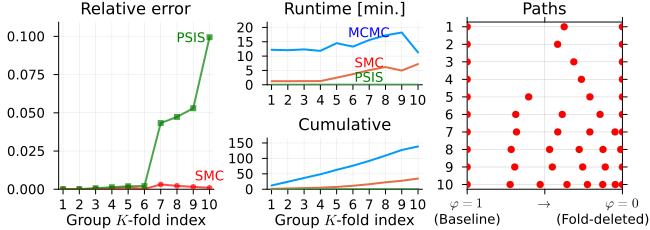

In [102]:
let
    # Compute weighted average estimates: MCMC-, SMC- and PSIS-LSO-CV
    est_mcmc = _mean(LPD_mcmc; dims=1)
    est_smc = [sum(LPD_smc[:, fold_i] .* weights_smc[fold_i])
        for (fold_i, _) in enumerate(data.valid_idx)]
    est_psis = [sum(LPD_psis[:, fold_i] .* weights_psis[fold_i])
        for (fold_i, _) in enumerate(data.valid_idx)]

    # Compute relative error per fold
    relErr_smc = abs.(est_mcmc - est_smc) ./ abs.(est_mcmc)
    relErr_psis = abs.(est_mcmc - est_psis) ./ abs.(est_mcmc)

    # Sort folds by PSIS error
    re_idx = relErr_psis |> sortperm

    """Plot 1: relative errors"""
    plot(relErr_smc[re_idx], color=:red, label="", linewidth=2, alpha=0.7,
        markershape=:o, ms=3, mswidth=0)
    plot!(relErr_psis[re_idx], color=:green, label="", linewidth=2, alpha=0.7,
        markershape=:square, ms=3, mswidth=0)
    plt_1 = plot!(title="Relative error",
        xlabel="Group "* L"K" * "-fold index", xticks=1:length(data.valid_idx),
        xtickfontsize=9, ytickfontsize=9,
        ylim=(0, 1.1maximum([relErr_smc; relErr_psis])))
    annotate!(10-0.3, relErr_psis[re_idx][end], text("PSIS", 9, :green, :right))
    annotate!(10+0.0, relErr_smc[re_idx][end] + 0.003, text("SMC", 9, :red, :bottom))

    # Used only for GIF figure
    #annotate!(2, 0.09, text(L"\hat{k}" * " Threshold:" * repeat("\n", 2), 9, :left))
    #for (i, threshold) in enumerate([-Inf, 0.5, 0.7, 0.9, +Inf])
    #    _txt = threshold == k̂_threshold ? text(threshold, 9, :red) : text(threshold, 8, :gray)
    #    annotate!(LinRange(2,7.5,5)[i], 0.09, _txt)
    #end

    # Load runtimes, reorder by sorted indices
    time_mcmc = load(joinpath("output", "M5", "mcmc",
            "times_naive-lso.jld"))["data"] / 60
    time_smc  = load(joinpath("output", "M5", "smc",
            "times_threshold-$(k̂_threshold).jld"))["data"] / 60
    time_psis = load(joinpath("output", "M5", "psis",
            "times_threshold-$(0.7).jld"))["data"] / 60
    _data     = [time_mcmc time_smc time_psis][re_idx, :]

    """Plot 2: runtimes"""
    plot(_data)
    annotate!(7, time_mcmc[re_idx][7], text("MCMC", :blue, 9, :bottom))
    annotate!(7, time_smc[re_idx][7],  text("SMC", :red, 9, :bottom))
    annotate!(7, time_psis[re_idx][7], text("PSIS", :green, 9, :bottom))
    plt_2 = plot(plot!(), plot(cumsum(_data; dims=1)); # overlay runtime + cumulative
        layout=grid(2,1,heights=[0.55, 0.45]),
        color=[:blue :red :green],
        title=["Runtime [min.]" "Cumulative"],
        label="",
        ylim=[(0, 1.2maximum(_data)) (0, 1.2maximum(cumsum(_data; dims=1)))],
        linewidth=2,
        xticks=1:length(data.valid_idx),
        xtickfontsize=9, ytickfontsize=9,
        xlabel=["" "Group "* L"K" * "-fold index"],
        #framestyle=:semi,
    )

    """Plot 3: fold-specific paths"""
    histories = load(joinpath("output", "M5", "smc",
            "histories_threshold-$(k̂_threshold).jld"))["data"][re_idx]
    plot(ymirror=false)
    for (g, history) in enumerate(histories)
        for ℓ in history
            if 0 < ℓ < 1
                #annotate!(ℓ - 0.0, g - 0.2, text("$(round(ℓ; digits=2)) ", :black, :right, 6, rotation=10))
            end
        end
        scatter!(history, repeat([g], length(history)), ms=4, mswidth=0.1, color=:red, label="")
    end
    _offset = 0.000
    plt_3 = plot!(
        xlim=(0-_offset, 1+_offset),
        xticks=([0, .5, 1], [L"\varphi = 1" * "\n(Baseline)", L"\rightarrow", L"\varphi = 0" * "\n(Fold-deleted)" * repeat(" ", 9)]),
        yticks=1:length(data.valid_idx),
        ytickfontsize=9,
        xtickfontsize=9,
        title="Paths",
        yflip=true,
        framestyle=:box,
    )

    plt = plot(plt_1, plt_2, plt_3, layout=grid(1,3), size=(650,230),
        bottommargin=3Plots.mm,
        rightmargin=[0Plots.mm 0Plots.mm 0Plots.mm 5Plots.mm],
        titlefontsize=11, xlabelfontsize=10, ylabelfontsize=10,
        tick_direction=:out,
    ) |> display

    #frame(anime, plot!(dpi=300))

    _dir = "img_$(SESSION)" * (k̂_threshold == 0.7 ? "" : "_threshold-$(k̂_threshold)")
    isdir(_dir) || mkpath(_dir) # Ensure path is present
    savefig(joinpath(_dir, "M5.pdf"))
end;

In [103]:
# gif(anime, fps=1)